In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from scipy.signal import find_peaks
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import joblib
import re
from tabulate import tabulate


#Load Data:
Membaca dataset Bitcoin dari URL url_btc ke dalam dataframe df_btc.

Membaca dataset Makroekonomi dari URL url_makro ke dalam dataframe df_makro.


In [ ]:
# URL dataset Bitcoin & Makroekonomi
url_btc = "https://raw.githubusercontent.com/adamzakys/SourceFiles/refs/heads/main/DatasetFinal/DF-Bitcoin.csv"
url_makro = "https://raw.githubusercontent.com/adamzakys/SourceFiles/refs/heads/main/DF-Makroekonomi-filtered2.csv"

# Baca dataset
df_btc = pd.read_csv(url_btc)
df_makro = pd.read_csv(url_makro)

# Tampilkan beberapa baris pertama dari kedua dataset
print("=== Data Bitcoin ===")
print(df_btc.head())

print("\n=== Data Makroekonomi ===")
print(df_makro.head())


=== Data Bitcoin ===
         Date     Price      Open      High       Low     Vol. Change %
0  12/31/2024  93,557.2  92,777.2  96,163.4  92,036.2   74.85K    0.84%
1  12/30/2024  92,779.8  93,718.7  94,936.4  91,522.3  112.43K   -1.00%
2  12/29/2024  93,716.3  95,282.6  95,315.4  93,026.7   47.71K   -1.65%
3  12/28/2024  95,284.5  94,274.9  95,684.3  94,124.7   32.97K    1.07%
4  12/27/2024  94,275.9  95,776.4  97,243.3  93,472.8   85.12K   -1.57%

=== Data Makroekonomi ===
      Tanggal Mata Uang                                 Event  Aktual
0  2018-01-03       EUR     German Unemployment Change  (Dec)    -29K
1  2018-01-03       EUR       German Unemployment Rate  (Dec)    5.5%
2  2018-01-03       USD          ISM Manufacturing PMI  (Dec)    59.7
3  2018-01-04       USD  ADP Nonfarm Employment Change  (Dec)    250K
4  2018-01-04       USD             Continuing Jobless Claims  1,914K


In [ ]:
print(df_makro.info)

<bound method DataFrame.info of          Tanggal Mata Uang                                 Event  Aktual
0     2018-01-03       EUR     German Unemployment Change  (Dec)    -29K
1     2018-01-03       EUR       German Unemployment Rate  (Dec)    5.5%
2     2018-01-03       USD          ISM Manufacturing PMI  (Dec)    59.7
3     2018-01-04       USD  ADP Nonfarm Employment Change  (Dec)    250K
4     2018-01-04       USD             Continuing Jobless Claims  1,914K
...          ...       ...                                   ...     ...
5341  2024-12-27       JPY           Tokyo Core CPI (YoY)  (Dec)    2.4%
5342  2024-12-30       USD                    Chicago PMI  (Dec)    36.9
5343  2024-12-31       CNY          Chinese Composite PMI  (Dec)    52.2
5344  2024-12-31       CNY              Manufacturing PMI  (Dec)    50.1
5345  2024-12-31       CNY          Non-Manufacturing PMI  (Dec)    52.2

[5346 rows x 4 columns]>


#Preprocessing


##a. Konversi Format Tanggal
 - Mengubah format kolom 'Date' di `df_btc` dan 'Tanggal' di `df_makro` menjadi tipe data datetime.
 - Menyamakan nama kolom tanggal menjadi 'Tanggal' di kedua dataframe.


In [ ]:
import pandas as pd

# Asumsikan df_btc dan df_makro sudah ada (misalnya dibaca dari file)
# Contoh pembuatan DataFrame dummy jika belum ada:
# df_btc = pd.DataFrame({'Date': ['2023-01-05', '2023/01/03', 'Invalid Date', '01-04-2023'], 'Price': [100, 110, 105, 115], 'Open': [95, 108, 100, 112]})
# df_makro = pd.DataFrame({'Tanggal': ['2023-01-05', '2023-01-03', '2023-01-04'], 'Mata Uang': ['IDR', 'USD', 'IDR'], 'Event': ['A', 'B', 'C'], 'Aktual': [1, 2, 3]})

print("=== Data Bitcoin SEBELUM diproses ===")
print(df_btc.head())
print("\n=== Data Makroekonomi SEBELUM diproses ===")
print(df_makro.head())
print("-" * 30)

# === GABUNGAN PROSES ===

# Konversi kolom 'Date' di df_btc ke tipe data datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'], errors='coerce')

# Konversi kolom 'Tanggal' di df_makro ke tipe data datetime
df_makro['Tanggal'] = pd.to_datetime(df_makro['Tanggal'], format='%Y-%m-%d', errors='coerce')

# Hapus baris dengan tanggal yang tidak valid (jika ada)
df_btc = df_btc.dropna(subset=['Date'])
df_makro = df_makro.dropna(subset=['Tanggal'])

# Urutkan df_btc berdasarkan tanggal dan atur ulang indeks
df_btc = df_btc.sort_values(by=['Date']).reset_index(drop=True)

# Buat kolom 'Tanggal' di df_btc agar konsisten dengan df_makro
df_btc['Tanggal'] = df_btc['Date']

# === Tampilkan Hasil Akhir ===
print("\n=== Data Bitcoin SETELAH konversi, sortir, dan penamaan ulang ===")
print(df_btc[['Tanggal', 'Price', 'Open']].head())

print("\n=== Data Makroekonomi SETELAH konversi tanggal ===")
print(df_makro[['Tanggal', 'Mata Uang', 'Event', 'Aktual']].head())

print("\nTipe data kolom tanggal df_btc:", df_btc['Tanggal'].dtype)
print("Tipe data kolom tanggal df_makro:", df_makro['Tanggal'].dtype)

=== Data Bitcoin SEBELUM diproses ===
         Date     Price      Open      High       Low     Vol. Change %
0  12/31/2024  93,557.2  92,777.2  96,163.4  92,036.2   74.85K    0.84%
1  12/30/2024  92,779.8  93,718.7  94,936.4  91,522.3  112.43K   -1.00%
2  12/29/2024  93,716.3  95,282.6  95,315.4  93,026.7   47.71K   -1.65%
3  12/28/2024  95,284.5  94,274.9  95,684.3  94,124.7   32.97K    1.07%
4  12/27/2024  94,275.9  95,776.4  97,243.3  93,472.8   85.12K   -1.57%

=== Data Makroekonomi SEBELUM diproses ===
      Tanggal Mata Uang                                 Event  Aktual
0  2018-01-03       EUR     German Unemployment Change  (Dec)    -29K
1  2018-01-03       EUR       German Unemployment Rate  (Dec)    5.5%
2  2018-01-03       USD          ISM Manufacturing PMI  (Dec)    59.7
3  2018-01-04       USD  ADP Nonfarm Employment Change  (Dec)    250K
4  2018-01-04       USD             Continuing Jobless Claims  1,914K
------------------------------

=== Data Bitcoin SETELAH konversi,

In [ ]:
df_makro.head().to_excel('5_data_teratas_df_makro.xlsx', index=False)

In [ ]:
# Tanggal awal df_btc
tanggal_awal_btc = df_btc['Tanggal'].min()

# Tanggal akhir df_btc
tanggal_akhir_btc = df_btc['Tanggal'].max()

# Tanggal awal df_makro
tanggal_awal_makro = df_makro['Tanggal'].min()

# Tanggal akhir df_makro
tanggal_akhir_makro = df_makro['Tanggal'].max()

print(f"Tanggal awal Bitcoin: {tanggal_awal_btc}")
print(f"Tanggal akhir Bitcoin: {tanggal_akhir_btc}")
print(f"Tanggal awal Makroekonomi: {tanggal_awal_makro}")
print(f"Tanggal akhir Makroekonomi: {tanggal_akhir_makro}")

Tanggal awal Bitcoin: 2018-01-01 00:00:00
Tanggal akhir Bitcoin: 2024-12-31 00:00:00
Tanggal awal Makroekonomi: 2018-01-03 00:00:00
Tanggal akhir Makroekonomi: 2024-12-31 00:00:00


##b. Membersihkan Data Makroekonom
 - Membersihkan data di kolom 'Aktual' pada `df_makro`, seperti menghapus simbol persen (%), mengubah 'K' menjadi '000', dan menangani angka ribuan.
 - Mendeteksi dan menangani duplikasi data berdasarkan 'Tanggal', 'Mata Uang', dan 'Event'.


In [ ]:
# Bersihkan data makroekonomi
def convert_to_float(value):
    value = str(value).replace('%', '').replace('K', '000').replace(',', '')  # Remove commas completely
    if 'M' in value:
        return float(value.replace('M', '')) * 1_000_000
    elif 'B' in value:
        return float(value.replace('B', '')) * 1_000_000_000  # Handle 'B' for billions
    elif 'T' in value:  # Handle 'T' for trillions
        return float(value.replace('T', '')) * 1_000_000_000_000
    else:
        return float(value)

df_makro['Aktual'] = df_makro['Aktual'].apply(convert_to_float)

# Deteksi duplikasi
df_makro = df_makro.groupby(['Tanggal', 'Mata Uang', 'Event'], as_index=False)['Aktual'].mean()

# Tampilkan hasil setelah membersihkan data
print("=== Data Makroekonomi setelah pembersihan ===")
print(df_makro.head())

=== Data Makroekonomi setelah pembersihan ===
     Tanggal Mata Uang                                 Event     Aktual
0 2018-01-03       EUR     German Unemployment Change  (Dec)   -29000.0
1 2018-01-03       EUR       German Unemployment Rate  (Dec)        5.5
2 2018-01-03       USD          ISM Manufacturing PMI  (Dec)       59.7
3 2018-01-04       USD  ADP Nonfarm Employment Change  (Dec)   250000.0
4 2018-01-04       USD             Continuing Jobless Claims  1914000.0


##c. Pivot Data Makroekonomi



### - Membersihkan nama event di kolom 'Event' pada `df_makro`.


In [ ]:
# Bersihkan nama event
def clean_event(event):
    return re.sub(r'\s+\((?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec|Q[1-4]|\d{4})\)', '', event)

df_makro['Event'] = df_makro['Event'].apply(clean_event)

# Gabungkan duplikat (misal GDP (YoY) dari Jan dan Feb digabung)
# Ensure 'Aktual' is numeric before grouping
df_makro['Aktual'] = pd.to_numeric(df_makro['Aktual'].astype(str).str.replace('%', '', regex=False), errors='coerce')
df_makro_grouped = df_makro.groupby(['Tanggal', 'Mata Uang', 'Event'], as_index=False)['Aktual'].mean()

### - Melakukan pivot data `df_makro` agar setiap indikator ekonomi menjadi kolom tersendiri.


In [ ]:
# Pivot ke wide format
df_makro_pivot = df_makro_grouped.pivot(index='Tanggal', columns=['Mata Uang', 'Event'], values='Aktual')
df_makro_pivot.columns = [f"{col[0]}_{col[1]}" for col in df_makro_pivot.columns]
df_makro_pivot.reset_index(inplace=True)

# Merge dengan df_btc
df_btc['Tanggal'] = pd.to_datetime(df_btc['Date'])
df_merged_cleaned = pd.merge(df_btc, df_makro_pivot, on='Tanggal', how='left')
print(df_merged_cleaned.head())

        Date     Price      Open      High       Low     Vol. Change %  \
0 2018-01-01  13,444.9  13,850.5  13,921.5  12,877.7   78.43K   -2.93%   
1 2018-01-02  14,754.1  13,444.9  15,306.1  12,934.2  137.73K    9.74%   
2 2018-01-03  15,156.6  14,754.1  15,435.0  14,579.7  106.54K    2.73%   
3 2018-01-04  15,180.1  15,156.5  15,408.7  14,244.7  110.97K    0.15%   
4 2018-01-05  16,954.8  15,180.1  17,126.9  14,832.4  141.96K   11.69%   

     Tanggal  EUR_German Unemployment Change  EUR_German Unemployment Rate  \
0 2018-01-01                             NaN                           NaN   
1 2018-01-02                             NaN                           NaN   
2 2018-01-03                        -29000.0                           5.5   
3 2018-01-04                             NaN                           NaN   
4 2018-01-05                             NaN                           NaN   

   ...  USD_Interest Rate Projection - 1st Yr  \
0  ...                               

##d. Menggabungkan Data
 - Menggabungkan `df_btc` dan `df_makro_pivot` (hasil pivot) berdasarkan kolom 'Tanggal' menjadi `df_merged`.


In [ ]:
# Gabungkan df_btc dengan df_makro berdasarkan kolom 'Tanggal'
df_merged = pd.merge(df_btc, df_makro_pivot, on='Tanggal', how='left')

# Tampilkan hasil penggabungan
print("=== Data Setelah Integrasi ===")
print(df_merged.head())

=== Data Setelah Integrasi ===
        Date     Price      Open      High       Low     Vol. Change %  \
0 2018-01-01  13,444.9  13,850.5  13,921.5  12,877.7   78.43K   -2.93%   
1 2018-01-02  14,754.1  13,444.9  15,306.1  12,934.2  137.73K    9.74%   
2 2018-01-03  15,156.6  14,754.1  15,435.0  14,579.7  106.54K    2.73%   
3 2018-01-04  15,180.1  15,156.5  15,408.7  14,244.7  110.97K    0.15%   
4 2018-01-05  16,954.8  15,180.1  17,126.9  14,832.4  141.96K   11.69%   

     Tanggal  EUR_German Unemployment Change  EUR_German Unemployment Rate  \
0 2018-01-01                             NaN                           NaN   
1 2018-01-02                             NaN                           NaN   
2 2018-01-03                        -29000.0                           5.5   
3 2018-01-04                             NaN                           NaN   
4 2018-01-05                             NaN                           NaN   

   ...  USD_Interest Rate Projection - 1st Yr  \
0  ...

##e. Penanganan Missing Values
Menampilkan jumlah missing values per kolom
Mengisi nilai yang hilang dengan forward fill (karena data makroekonomi diperbarui berkala)
Menampilkan hasil setelah penanganan missing values


### - Mendeteksi dan menampilkan jumlah missing values di `df_merged`.


In [ ]:
# Cek jumlah missing values per kolom
missing_counts = df_merged.isnull().sum()

# Tampilkan hanya kolom yang memiliki missing values
print("=== Missing Values Sebelum Penanganan ===")
print(missing_counts[missing_counts > 0])

=== Missing Values Sebelum Penanganan ===
EUR_German Unemployment Change       2473
EUR_German Unemployment Rate         2473
USD_ISM Manufacturing PMI            2473
USD_ADP Nonfarm Employment Change    2475
USD_Continuing Jobless Claims        2192
                                     ... 
CNY_PBoC Loan Prime Rate             2493
CNY_Chinese GDP YTD  (YoY)           2536
CNY_China Loan Prime Rate 5Y         2540
USD_Atlanta Fed GDPNow               2465
JPY_GDP Annualized (QoQ)             2556
Length: 68, dtype: int64


### - Mengisi missing values dengan metode forward fill dan backward fill.
metode forward fill agar data tetap berkelanjutan

In [ ]:
# Isi missing values dengan forward fill
df_merged.fillna(method='ffill', inplace=True)

# Jika masih ada missing values di awal data, isi dengan backward fill sebagai cadangan
df_merged.fillna(method='bfill', inplace=True)

# Cek kembali jumlah missing values setelah diisi
print("=== Missing Values Setelah Penanganan ===")
print(df_merged.isnull().sum().sum())  # Jika hasilnya 0, berarti sudah bersih

=== Missing Values Setelah Penanganan ===
5114


<ipython-input-12-646ed28b20ec>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)
<ipython-input-12-646ed28b20ec>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='bfill', inplace=True)


In [ ]:
# Tampilkan beberapa baris data setelah handling missing values
print("=== Data Setelah Penanganan Missing Values ===")
print(df_merged.head(10))

=== Data Setelah Penanganan Missing Values ===
        Date     Price      Open      High       Low     Vol. Change %  \
0 2018-01-01  13,444.9  13,850.5  13,921.5  12,877.7   78.43K   -2.93%   
1 2018-01-02  14,754.1  13,444.9  15,306.1  12,934.2  137.73K    9.74%   
2 2018-01-03  15,156.6  14,754.1  15,435.0  14,579.7  106.54K    2.73%   
3 2018-01-04  15,180.1  15,156.5  15,408.7  14,244.7  110.97K    0.15%   
4 2018-01-05  16,954.8  15,180.1  17,126.9  14,832.4  141.96K   11.69%   
5 2018-01-06  17,172.3  16,954.8  17,252.8  16,286.6   83.93K    1.28%   
6 2018-01-07  16,228.2  17,174.5  17,184.8  15,791.1   79.01K   -5.50%   
7 2018-01-08  14,976.2  16,228.3  16,302.9  13,902.3  142.45K   -7.71%   
8 2018-01-09  14,778.5  14,976.2  15,324.6  14,613.4   71.40K   -1.32%   
9 2018-01-10  15,043.0  14,778.5  15,045.4  13,613.1   87.07K    1.79%   

     Tanggal  EUR_German Unemployment Change  EUR_German Unemployment Rate  \
0 2018-01-01                        -29000.0                

In [ ]:
# Hapus kolom yg masih ada Nan
df_merged.dropna(axis=1, inplace=True)

print(df_merged.head())
df_merged.dtypes

        Date     Price      Open      High       Low     Vol. Change %  \
0 2018-01-01  13,444.9  13,850.5  13,921.5  12,877.7   78.43K   -2.93%   
1 2018-01-02  14,754.1  13,444.9  15,306.1  12,934.2  137.73K    9.74%   
2 2018-01-03  15,156.6  14,754.1  15,435.0  14,579.7  106.54K    2.73%   
3 2018-01-04  15,180.1  15,156.5  15,408.7  14,244.7  110.97K    0.15%   
4 2018-01-05  16,954.8  15,180.1  17,126.9  14,832.4  141.96K   11.69%   

     Tanggal  EUR_German Unemployment Change  EUR_German Unemployment Rate  \
0 2018-01-01                        -29000.0                           5.5   
1 2018-01-02                        -29000.0                           5.5   
2 2018-01-03                        -29000.0                           5.5   
3 2018-01-04                        -29000.0                           5.5   
4 2018-01-05                        -29000.0                           5.5   

   ...  USD_Interest Rate Projection - 1st Yr  \
0  ...                               

,0
Date,datetime64[ns]
Price,object
Open,object
High,object
Low,object
...,...
CNY_PBoC Loan Prime Rate,float64
CNY_Chinese GDP YTD (YoY),float64
CNY_China Loan Prime Rate 5Y,float64
USD_Atlanta Fed GDPNow,float64


In [ ]:
# Hapus kolom "Date" karena "Tanggal" sudah cukup
df_merged.drop(columns=['Date'], inplace=True)

# Cek apakah "Date" sudah hilang
df_merged

,Price,Open,High,Low,Vol.,Change %,Tanggal,EUR_German Unemployment Change,EUR_German Unemployment Rate,USD_ISM Manufacturing PMI,...,USD_Interest Rate Projection - 1st Yr,USD_Interest Rate Projection - 2nd Yr,USD_Interest Rate Projection - 3rd Yr,USD_Interest Rate Projection - Current,USD_Interest Rate Projection - Longer,CNY_PBoC Loan Prime Rate,CNY_Chinese GDP YTD (YoY),CNY_China Loan Prime Rate 5Y,USD_Atlanta Fed GDPNow,JPY_GDP Annualized (QoQ)
0,"13,444.9","13,850.5","13,921.5","12,877.7",78.43K,-2.93%,2018-01-01,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
1,"14,754.1","13,444.9","15,306.1","12,934.2",137.73K,9.74%,2018-01-02,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
2,"15,156.6","14,754.1","15,435.0","14,579.7",106.54K,2.73%,2018-01-03,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
3,"15,180.1","15,156.5","15,408.7","14,244.7",110.97K,0.15%,2018-01-04,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
4,"16,954.8","15,180.1","17,126.9","14,832.4",141.96K,11.69%,2018-01-05,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,"94,275.9","95,776.4","97,243.3","93,472.8",85.12K,-1.57%,2024-12-27,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2553,"95,284.5","94,274.9","95,684.3","94,124.7",32.97K,1.07%,2024-12-28,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2554,"93,716.3","95,282.6","95,315.4","93,026.7",47.71K,-1.65%,2024-12-29,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2555,"92,779.8","93,718.7","94,936.4","91,522.3",112.43K,-1.00%,2024-12-30,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2


In [ ]:
df_merged

,Price,Open,High,Low,Vol.,Change %,Tanggal,EUR_German Unemployment Change,EUR_German Unemployment Rate,USD_ISM Manufacturing PMI,...,USD_Interest Rate Projection - 1st Yr,USD_Interest Rate Projection - 2nd Yr,USD_Interest Rate Projection - 3rd Yr,USD_Interest Rate Projection - Current,USD_Interest Rate Projection - Longer,CNY_PBoC Loan Prime Rate,CNY_Chinese GDP YTD (YoY),CNY_China Loan Prime Rate 5Y,USD_Atlanta Fed GDPNow,JPY_GDP Annualized (QoQ)
0,"13,444.9","13,850.5","13,921.5","12,877.7",78.43K,-2.93%,2018-01-01,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
1,"14,754.1","13,444.9","15,306.1","12,934.2",137.73K,9.74%,2018-01-02,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
2,"15,156.6","14,754.1","15,435.0","14,579.7",106.54K,2.73%,2018-01-03,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
3,"15,180.1","15,156.5","15,408.7","14,244.7",110.97K,0.15%,2018-01-04,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
4,"16,954.8","15,180.1","17,126.9","14,832.4",141.96K,11.69%,2018-01-05,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,"94,275.9","95,776.4","97,243.3","93,472.8",85.12K,-1.57%,2024-12-27,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2553,"95,284.5","94,274.9","95,684.3","94,124.7",32.97K,1.07%,2024-12-28,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2554,"93,716.3","95,282.6","95,315.4","93,026.7",47.71K,-1.65%,2024-12-29,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2555,"92,779.8","93,718.7","94,936.4","91,522.3",112.43K,-1.00%,2024-12-30,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2


##f. Perbaikan Format Data

### - Mengubah format data di kolom 'Vol.' dan 'Change %' menjadi numerik.

In [ ]:
# Fungsi untuk mengubah format K, M, B menjadi angka float
def convert_volume(value):
    value = str(value).replace(',', '')  # Hilangkan koma ribuan
    if 'K' in value:
        return float(value.replace('K', '')) * 1_000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1_000_000
    elif 'B' in value:
        return float(value.replace('B', '')) * 1_000_000_000
    else:
        return float(value)

# Terapkan fungsi ke kolom Volume
df_merged['Vol.'] = df_merged['Vol.'].apply(convert_volume)
# Hilangkan persen dan ubah ke float
df_merged['Change %'] = df_merged['Change %'].str.replace('%', '').astype(float)
df_merged

,Price,Open,High,Low,Vol.,Change %,Tanggal,EUR_German Unemployment Change,EUR_German Unemployment Rate,USD_ISM Manufacturing PMI,...,USD_Interest Rate Projection - 1st Yr,USD_Interest Rate Projection - 2nd Yr,USD_Interest Rate Projection - 3rd Yr,USD_Interest Rate Projection - Current,USD_Interest Rate Projection - Longer,CNY_PBoC Loan Prime Rate,CNY_Chinese GDP YTD (YoY),CNY_China Loan Prime Rate 5Y,USD_Atlanta Fed GDPNow,JPY_GDP Annualized (QoQ)
0,"13,444.9","13,850.5","13,921.5","12,877.7",78430.0,-2.93,2018-01-01,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
1,"14,754.1","13,444.9","15,306.1","12,934.2",137730.0,9.74,2018-01-02,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
2,"15,156.6","14,754.1","15,435.0","14,579.7",106540.0,2.73,2018-01-03,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
3,"15,180.1","15,156.5","15,408.7","14,244.7",110970.0,0.15,2018-01-04,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
4,"16,954.8","15,180.1","17,126.9","14,832.4",141960.0,11.69,2018-01-05,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,"94,275.9","95,776.4","97,243.3","93,472.8",85120.0,-1.57,2024-12-27,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2553,"95,284.5","94,274.9","95,684.3","94,124.7",32970.0,1.07,2024-12-28,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2554,"93,716.3","95,282.6","95,315.4","93,026.7",47710.0,-1.65,2024-12-29,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2555,"92,779.8","93,718.7","94,936.4","91,522.3",112430.0,-1.00,2024-12-30,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2


###bah Format Angka Ribuan (94,560.2 → 94560.2)
 - Mengubah format angka ribuan di kolom harga Bitcoin (Price, Open, High, Low) menjadi numerik.


In [ ]:
# Konversi kolom harga Bitcoin ke float
numeric_cols = ['Price', 'Open', 'High', 'Low']
df_merged[numeric_cols] = df_merged[numeric_cols].replace(',', '', regex=True).astype(float)
df_merged

,Price,Open,High,Low,Vol.,Change %,Tanggal,EUR_German Unemployment Change,EUR_German Unemployment Rate,USD_ISM Manufacturing PMI,...,USD_Interest Rate Projection - 1st Yr,USD_Interest Rate Projection - 2nd Yr,USD_Interest Rate Projection - 3rd Yr,USD_Interest Rate Projection - Current,USD_Interest Rate Projection - Longer,CNY_PBoC Loan Prime Rate,CNY_Chinese GDP YTD (YoY),CNY_China Loan Prime Rate 5Y,USD_Atlanta Fed GDPNow,JPY_GDP Annualized (QoQ)
0,13444.9,13850.5,13921.5,12877.7,78430.0,-2.93,2018-01-01,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
1,14754.1,13444.9,15306.1,12934.2,137730.0,9.74,2018-01-02,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
2,15156.6,14754.1,15435.0,14579.7,106540.0,2.73,2018-01-03,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
3,15180.1,15156.5,15408.7,14244.7,110970.0,0.15,2018-01-04,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
4,16954.8,15180.1,17126.9,14832.4,141960.0,11.69,2018-01-05,-29000.0,5.5,59.7,...,1.9,2.1,2.4,1.9,2.5,4.2,6.2,4.2,2.3,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,94275.9,95776.4,97243.3,93472.8,85120.0,-1.57,2024-12-27,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2553,95284.5,94274.9,95684.3,94124.7,32970.0,1.07,2024-12-28,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2554,93716.3,95282.6,95315.4,93026.7,47710.0,-1.65,2024-12-29,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2
2555,92779.8,93718.7,94936.4,91522.3,112430.0,-1.00,2024-12-30,7000.0,6.1,48.4,...,3.9,3.4,3.1,4.4,3.0,3.1,4.8,3.6,3.1,1.2


In [ ]:
print(df_merged.head())

     Price     Open     High      Low      Vol.  Change %    Tanggal  \
0  13444.9  13850.5  13921.5  12877.7   78430.0     -2.93 2018-01-01   
1  14754.1  13444.9  15306.1  12934.2  137730.0      9.74 2018-01-02   
2  15156.6  14754.1  15435.0  14579.7  106540.0      2.73 2018-01-03   
3  15180.1  15156.5  15408.7  14244.7  110970.0      0.15 2018-01-04   
4  16954.8  15180.1  17126.9  14832.4  141960.0     11.69 2018-01-05   

   EUR_German Unemployment Change  EUR_German Unemployment Rate  \
0                        -29000.0                           5.5   
1                        -29000.0                           5.5   
2                        -29000.0                           5.5   
3                        -29000.0                           5.5   
4                        -29000.0                           5.5   

   USD_ISM Manufacturing PMI  ...  USD_Interest Rate Projection - 1st Yr  \
0                       59.7  ...                                    1.9   
1           

#Analisa Data Sebelum Normalisasi

##a. Identifikasi Titik Ekstrem (ATH/ATL)

### - Mendeteksi titik tertinggi (ATH) dan terendah (ATL) lokal dan global pada harga Bitcoin.


In [ ]:
# === PARAMETER YANG BISA DIUBAH ===
window_days = 3
macro_cols = ['EUR_German Unemployment Change', 'EUR_German Unemployment Rate', 'USD_ISM Manufacturing PMI', 'USD_ADP Nonfarm Employment Change', 'USD_Continuing Jobless Claims', 'USD_Initial Jobless Claims', 'USD_ISM Non-Manufacturing PMI', 'USD_Nonfarm Payrolls', 'USD_Private Nonfarm Payrolls', 'USD_U6 Unemployment Rate', 'USD_Unemployment Rate', 'CNY_CPI (MoM)', 'CNY_CPI (YoY)', 'GBP_NIESR GDP Estimate', 'USD_CPI (MoM)', 'USD_CPI (YoY)', 'USD_Core CPI (MoM)', 'USD_Core CPI (YoY)', 'EUR_German CPI (MoM)', 'EUR_German CPI (YoY)', 'GBP_CPI (MoM)', 'GBP_CPI (YoY)', 'GBP_CPIH (YoY)', 'CNY_GDP (QoQ)', 'CNY_GDP (YoY)', 'JPY_BoJ Interest Rate Decision', 'GBP_Unemployment Rate', 'GBP_GDP (QoQ)', 'GBP_GDP (YoY)', 'JPY_National CPI (MoM)', 'JPY_National Core CPI (YoY)', 'JPY_Tokyo Core CPI (YoY)', 'USD_Core PCE Prices', 'USD_GDP (QoQ)', 'USD_GDP Price Index (QoQ)', 'USD_Core PCE Price Index (MoM)', 'USD_Core PCE Price Index (YoY)', 'JPY_BoJ Core CPI (YoY)', 'CNY_Manufacturing PMI', 'CNY_Non-Manufacturing PMI', 'USD_Chicago PMI', 'USD_Fed Interest Rate Decision', 'GBP_BoE Interest Rate Decision', 'EUR_German GDP (QoQ)', 'EUR_German GDP (YoY)', 'JPY_GDP (QoQ)', 'JPY_GDP (YoY)', 'JPY_GDP Price Index (YoY)', 'GBP_Employment Change 3M/3M (MoM)', 'CNY_Chinese Unemployment Rate', 'GBP_GDP (MoM)', 'GBP_NIESR Monthly GDP Tracker', 'GBP_Monthly GDP 3M/3M Change', 'CNY_Chinese Composite PMI', 'USD_PCE Price index (YoY)', 'USD_PCE price index (MoM)', 'USD_Interest Rate Projection - 1st Yr', 'USD_Interest Rate Projection - 2nd Yr', 'USD_Interest Rate Projection - 3rd Yr', 'USD_Interest Rate Projection - Current', 'USD_Interest Rate Projection - Longer', 'CNY_PBoC Loan Prime Rate', 'CNY_Chinese GDP YTD  (YoY)', 'CNY_China Loan Prime Rate 5Y', 'USD_Atlanta Fed GDPNow']  # Ganti sesuai kolom di df_merged
price_col = 'Price'

# === SIAPKAN DATA SALINAN ===
df_price_extreme = df_merged.copy()
df_price_extreme['Tanggal'] = pd.to_datetime(df_price_extreme['Tanggal'])  # Changed 'Date' to 'Tanggal'
df_price_extreme = df_price_extreme.sort_values('Tanggal').reset_index(drop=True)  # Changed 'Date' to 'Tanggal'

# === IDENTIFIKASI PUNCAK DAN LEMBAH LOKAL ===
price_series = df_price_extreme[price_col]
peaks, _ = find_peaks(price_series, distance=30)
troughs, _ = find_peaks(-price_series, distance=30)

df_price_extreme['ATH_Local'] = 0
df_price_extreme.loc[peaks, 'ATH_Local'] = 1
df_price_extreme['ATL_Local'] = 0
df_price_extreme.loc[troughs, 'ATL_Local'] = 1

# Titik global
ath_global_idx = price_series.idxmax()
atl_global_idx = price_series.idxmin()

df_price_extreme['ATH_Global'] = 0
df_price_extreme['ATL_Global'] = 0
df_price_extreme.loc[ath_global_idx, 'ATH_Global'] = 1
df_price_extreme.loc[atl_global_idx, 'ATL_Global'] = 1

# === FUNGSI UTAMA: DETEKSI PERUBAHAN EVENT SEKITAR ATH/ATL ===
def detect_event_changes(df, idx, macro_cols, window=3):
    """
    Ambil perubahan nilai indikator makro dalam ±window hari dari titik event.
    """
    center_date = df.loc[idx, 'Tanggal']  # Changed 'Date' to 'Tanggal'
    event_type = 'ATH' if df.loc[idx, 'ATH_Local'] else 'ATL'
    price = df.loc[idx, price_col]

    output = [f"[{event_type}] Tanggal: {center_date.date()} | Harga: ${price:,.2f}"]

    for offset in range(-window, window + 1):
        if offset == 0:
            continue
        date_check = center_date + pd.Timedelta(days=offset)
        label = f"{abs(offset)} hari {'sebelumnya' if offset < 0 else 'setelahnya'}"

        row_curr = df[df['Tanggal'] == date_check]  # Changed 'Date' to 'Tanggal'
        if row_curr.empty:
            continue

        row_prev = df[df['Tanggal'] == date_check - pd.Timedelta(days=1)]  # Changed 'Date' to 'Tanggal'
        if row_prev.empty:
            continue

        for col in macro_cols:
            val_curr = row_curr[col].values[0]
            val_prev = row_prev[col].values[0]

            if pd.notnull(val_curr) and pd.notnull(val_prev) and val_curr != val_prev:
                change = f"- {label}: {col} berubah dari {val_prev:.2f} ke {val_curr:.2f}"
                output.append(change)

    return "\n".join(output)

# === JALANKAN UNTUK SEMUA ATH/ATL LOKAL ===
output_all_events = []

for idx in df_price_extreme.index:
    if df_price_extreme.loc[idx, 'ATH_Local'] or df_price_extreme.loc[idx, 'ATL_Local']:
        result = detect_event_changes(df_price_extreme, idx, macro_cols, window=window_days)
        if result:
            output_all_events.append(result)

# === CETAK OUTPUT DESKRIPTIF ===
for item in output_all_events:
    print(item)
    print("-" * 80)

# === INFORMASIKAN GLOBAL ATH/ATL ===
ath_global_row = df_price_extreme.loc[ath_global_idx]
atl_global_row = df_price_extreme.loc[atl_global_idx]

print(">>> TITIK TERTINGGI (ATH GLOBAL):")
print(f"Tanggal: {ath_global_row['Tanggal'].date()} | Harga: ${ath_global_row[price_col]:,.2f}")  # Changed 'Date' to 'Tanggal'
print(">>> TITIK TERENDAH (ATL GLOBAL):")
print(f"Tanggal: {atl_global_row['Tanggal'].date()} | Harga: ${atl_global_row[price_col]:,.2f}")  # Changed 'Date' to 'Tanggal'

[ATH] Tanggal: 2018-01-06 | Harga: $17,172.30
--------------------------------------------------------------------------------
[ATL] Tanggal: 2018-02-05 | Harga: $6,938.50
- 3 hari sebelumnya: USD_Nonfarm Payrolls berubah dari 148000.00 ke 200000.00
- 3 hari sebelumnya: USD_Private Nonfarm Payrolls berubah dari 146000.00 ke 196000.00
- 3 hari sebelumnya: USD_U6 Unemployment Rate berubah dari 8.10 ke 8.20
- 3 hari setelahnya: USD_Continuing Jobless Claims berubah dari 1953000.00 ke 1923000.00
- 3 hari setelahnya: USD_Initial Jobless Claims berubah dari 230000.00 ke 221000.00
--------------------------------------------------------------------------------
[ATH] Tanggal: 2018-03-04 | Harga: $11,416.50
- 3 hari sebelumnya: USD_ISM Manufacturing PMI berubah dari 59.10 ke 60.80
- 3 hari sebelumnya: USD_Continuing Jobless Claims berubah dari 1875000.00 ke 1931000.00
- 3 hari sebelumnya: USD_Initial Jobless Claims berubah dari 222000.00 ke 210000.00
- 3 hari sebelumnya: USD_Core PCE Price Inde

### - Menganalisis perubahan event makroekonomi di sekitar titik-titik ekstrem dengan visualisasi.

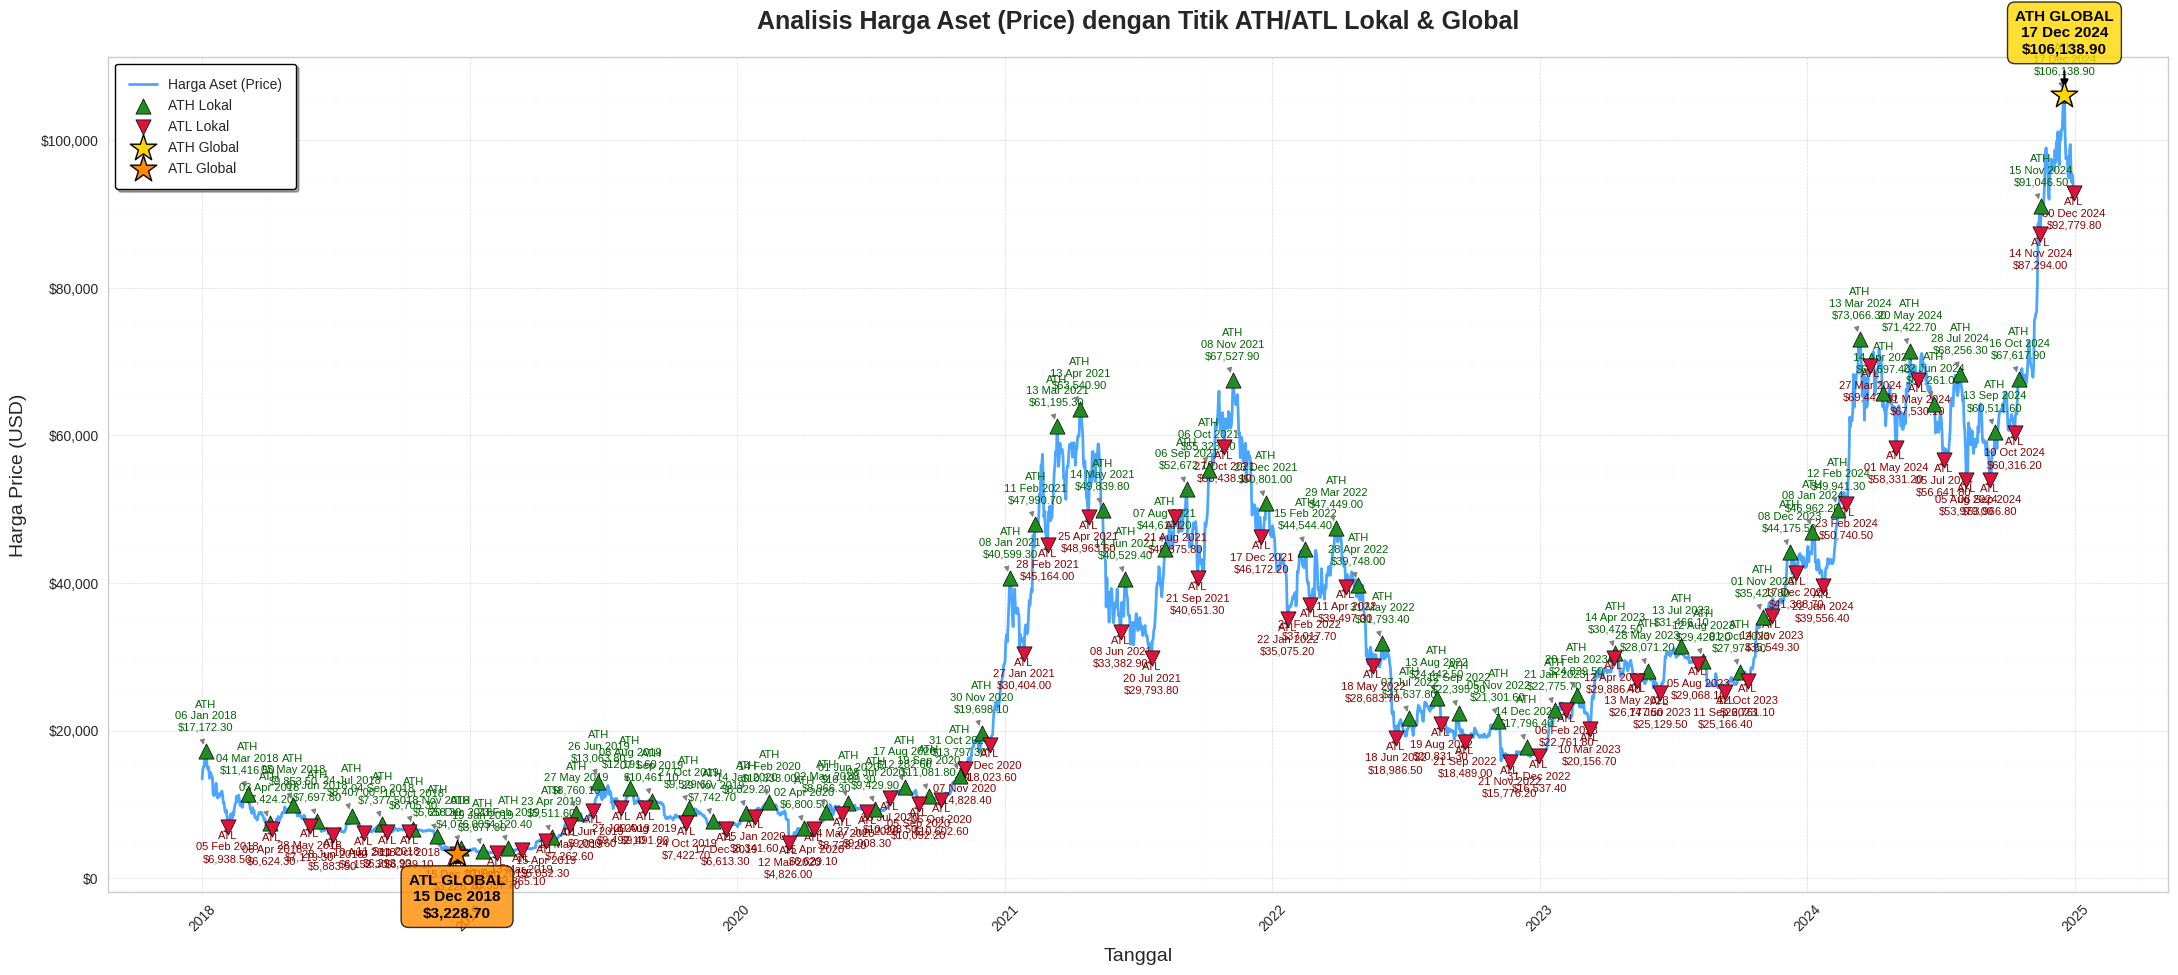

In [ ]:
df_plot = df_price_extreme.copy()
if not pd.api.types.is_datetime64_any_dtype(df_plot['Tanggal']):
    df_plot['Tanggal'] = pd.to_datetime(df_plot['Tanggal'])
df_plot = df_plot.set_index('Tanggal')

# --- Membuat Plot ---
plt.style.use('seaborn-v0_8-whitegrid') # Menggunakan style yang sedikit berbeda untuk estetika
plt.figure(figsize=(22, 10)) # Perbesar ukuran figure agar anotasi lebih mudah dibaca
ax = sns.lineplot(data=df_plot, x=df_plot.index, y=price_col, label=f'Harga Aset ({price_col})', linewidth=2, color='dodgerblue', alpha=0.8)

# --- Menandai dan Menganotasi ATH Lokal ---
ath_local_points = df_plot[df_plot['ATH_Local'] == 1]
plt.scatter(ath_local_points.index, ath_local_points[price_col],
            color='forestgreen', label='ATH Lokal', marker='^', s=120, zorder=5, edgecolor='black', linewidth=0.5)

# Anotasi ATH Lokal
for date_idx, row_data in ath_local_points.iterrows():
    price_val = row_data[price_col]
    ax.annotate(f"ATH\n{date_idx.strftime('%d %b %Y')}\n${price_val:,.2f}",
                 (date_idx, price_val),
                 textcoords="offset points",
                 xytext=(0,15), # Offset teks dari titik
                 ha='center', # Horizontal alignment
                 fontsize=8,
                 color='darkgreen',
                 arrowprops=dict(arrowstyle="-|>", color='gray', shrinkA=5, shrinkB=5, lw=0.7, connectionstyle="arc3,rad=.2"))

# --- Menandai dan Menganotasi ATL Lokal ---
atl_local_points = df_plot[df_plot['ATL_Local'] == 1]
plt.scatter(atl_local_points.index, atl_local_points[price_col],
            color='crimson', label='ATL Lokal', marker='v', s=120, zorder=5, edgecolor='black', linewidth=0.5)

# Anotasi ATL Lokal
for date_idx, row_data in atl_local_points.iterrows():
    price_val = row_data[price_col]
    ax.annotate(f"ATL\n{date_idx.strftime('%d %b %Y')}\n${price_val:,.2f}",
                 (date_idx, price_val),
                 textcoords="offset points",
                 xytext=(0,-25), # Offset teks ke bawah
                 ha='center',
                 fontsize=8,
                 color='darkred',
                 arrowprops=dict(arrowstyle="-|>", color='gray', shrinkA=5, shrinkB=5, lw=0.7, connectionstyle="arc3,rad=-.2"))

# --- Menandai dan Menganotasi ATH Global ---
ath_global_point = df_plot[df_plot['ATH_Global'] == 1]
if not ath_global_point.empty:
    ath_g_date = ath_global_point.index[0]
    ath_g_price = ath_global_point[price_col].iloc[0]
    plt.scatter(ath_g_date, ath_g_price,
                color='gold', label='ATH Global', marker='*', s=400, zorder=7, edgecolor='black', linewidth=1)
    ax.annotate(f"ATH GLOBAL\n{ath_g_date.strftime('%d %b %Y')}\n${ath_g_price:,.2f}",
                 (ath_g_date, ath_g_price),
                 textcoords="offset points",
                 xytext=(0, 30), # Penyesuaian offset
                 ha='center',
                 fontsize=11,
                 fontweight='bold',
                 color='black',
                 bbox=dict(boxstyle="round,pad=0.5", fc="gold", ec="black", lw=1, alpha=0.8),
                 arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", color='black', lw=1.5, shrinkA=5, shrinkB=5))

# --- Menandai dan Menganotasi ATL Global ---
atl_global_point = df_plot[df_plot['ATL_Global'] == 1]
if not atl_global_point.empty:
    atl_g_date = atl_global_point.index[0]
    atl_g_price = atl_global_point[price_col].iloc[0]
    plt.scatter(atl_g_date, atl_g_price,
                color='darkorange', label='ATL Global', marker='*', s=400, zorder=7, edgecolor='black', linewidth=1)
    ax.annotate(f"ATL GLOBAL\n{atl_g_date.strftime('%d %b %Y')}\n${atl_g_price:,.2f}",
                 (atl_g_date, atl_g_price),
                 textcoords="offset points",
                 xytext=(0, -45), # Penyesuaian offset
                 ha='center',
                 fontsize=11,
                 fontweight='bold',
                 color='black',
                 bbox=dict(boxstyle="round,pad=0.5", fc="darkorange", ec="black", lw=1, alpha=0.8),
                 arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", color='black', lw=1.5, shrinkA=5, shrinkB=5))

# --- Styling Tambahan dan Informasi ---
plt.title(f"Analisis Harga Aset ({price_col}) dengan Titik ATH/ATL Lokal & Global", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Tanggal", fontsize=14, labelpad=10)
plt.ylabel(f"Harga {price_col} (USD)", fontsize=14, labelpad=10)

# Kustomisasi legenda
legend = plt.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True, borderpad=1)
legend.get_frame().set_edgecolor('black')

# Kustomisasi tick parameters
plt.xticks(fontsize=10, rotation=45) # Rotasi label tanggal agar tidak tumpang tindih
plt.yticks(fontsize=10)
ax.tick_params(axis='both', which='major', pad=7)

# Format y-axis untuk menampilkan sebagai mata uang
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, _: f'${y:,.0f}')
ax.yaxis.set_major_formatter(formatter)

ax.minorticks_on()
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.4)


plt.tight_layout(pad=1.5) # Memberi padding agar semua elemen terlihat jelas
plt.show()

##b. Analisis Volatilitas


### - Menghitung volatilitas harga Bitcoin.


In [ ]:
# # Salin data
# df_analysis = df_merged.copy()

# # Hitung volatilitas dan rolling std
# df_analysis['Volatility'] = (df_analysis['High'] - df_analysis['Low']) / df_analysis['Open'] * 100
# df_analysis['Change %'] = (df_analysis['Price'] - df_analysis['Open']) / df_analysis['Open'] * 100
# df_analysis['Volatility'] = df_analysis['Change %'].rolling(window=30).std()

# # Ambang batas volatilitas tinggi
# avg_volatility = df_analysis['Volatility'].mean()
# std_volatility = df_analysis['Volatility'].std()
# high_volatility_threshold = avg_volatility + 2 * std_volatility

# # Periode volatilitas tinggi
# high_volatility_periods = df_analysis[df_analysis['Volatility'] > high_volatility_threshold]

# # Kolom indikator makroekonomi
# btc_cols = ['Tanggal', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
# macro_cols = [col for col in df_analysis.columns if col not in btc_cols and col != 'Volatility']

# # Siapkan data perubahan
# df_changes = df_analysis[['Tanggal'] + macro_cols].copy()
# df_changes_shifted = df_changes.copy()
# df_changes_shifted[macro_cols] = df_changes_shifted[macro_cols].shift(1)

# # Output penyebab
# cause_analysis = {}
# for date in high_volatility_periods['Tanggal']:
#     window_start = pd.to_datetime(date) - pd.DateOffset(days=10)
#     window_end = pd.to_datetime(date)

#     mask = (df_changes['Tanggal'] >= window_start) & (df_changes['Tanggal'] <= window_end)
#     current_window = df_changes.loc[mask].reset_index(drop=True)
#     previous_window = df_changes_shifted.loc[mask].reset_index(drop=True)

#     significant = []
#     for i in range(len(current_window)):
#         row_now = current_window.loc[i]
#         row_prev = previous_window.loc[i]
#         for col in macro_cols:
#             val_now = row_now[col]
#             val_prev = row_prev[col]
#             if pd.notna(val_now) and pd.notna(val_prev):
#                 delta = val_now - val_prev
#                 if delta != 0:
#                     significant.append({
#                         'Tanggal Perubahan': row_now['Tanggal'],
#                         'Indikator': col,
#                         'Dari': val_prev,
#                         'Ke': val_now,
#                         'Perubahan': delta
#                     })

#     if significant:
#         cause_analysis[date] = significant

# def visualize_volatility(df, volatility_col='Volatility', date_col='Tanggal', top_n=3):
#     # Ambang batas: rata-rata + 1 std
#     high_volatility_threshold = df[volatility_col].mean() + df[volatility_col].std()
#     df_high = df[df[volatility_col] > high_volatility_threshold]

#     plt.figure(figsize=(18,6))
#     plt.plot(df[date_col], df[volatility_col], label='Volatilitas Bitcoin', color='steelblue')
#     plt.axhline(high_volatility_threshold, color='red', linestyle='--', label='Ambang Batas Volatilitas Tinggi')
#     plt.scatter(df_high[date_col], df_high[volatility_col], color='red', s=50, label='Titik Volatilitas Tinggi')

#     # Anotasi hanya pada N titik tertinggi
#     top_high = df_high.sort_values(by=volatility_col, ascending=False).head(top_n)
#     for _, row in top_high.iterrows():
#         plt.annotate(row[date_col].strftime('%Y-%m-%d'),
#                      xy=(row[date_col], row[volatility_col]),
#                      xytext=(row[date_col], row[volatility_col] + 10),
#                      textcoords='data',
#                      arrowprops=dict(facecolor='gray', arrowstyle='->'),
#                      fontsize=9, ha='center', rotation=30)

#     plt.title("Volatilitas Bitcoin 30-Hari Rolling StdDev", fontsize=14)
#     plt.xlabel("Tanggal")
#     plt.ylabel("Volatilitas (%)")
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()


# # Output hasil akhir
# print("\n📊 Penyebab Volatilitas Tinggi (dengan nilai awal dan akhir):")
# for date, changes in cause_analysis.items():
#     print(f"\n📌 Tanggal Volatilitas Tinggi: {date}")
#     for change in changes:
#         tgl = change['Tanggal Perubahan']
#         indikator = change['Indikator']
#         dari = change['Dari']
#         ke = change['Ke']
#         delta = change['Perubahan']
#         print(f" - {tgl.date()} | {indikator}: dari {dari:.2f} ke {ke:.2f} (Δ {delta:+.2f})")

# # Konversi hasil ke DataFrame
# all_records = []
# for date, events in cause_analysis.items():
#     for event in events:
#         all_records.append({
#             'Tanggal Volatilitas': date,
#             'Tanggal Perubahan': event['Tanggal Perubahan'],
#             'Indikator': event['Indikator'],
#             'Dari': event['Dari'],
#             'Ke': event['Ke'],
#             'Delta': event['Perubahan']
#         })

# df_event_causes = pd.DataFrame(all_records)


📊 Analisis Penyebab Potensial untuk Periode Volatilitas Tinggi:

📌 Tanggal Volatilitas Tinggi: 2018-01-31 (Vol: 637.98%)
  - [2018-01-31] EUR_German Unemployment Change: dari -29000.00 ke -25000.00 (Perubahan: +4000.00)
  - [2018-01-31] EUR_German Unemployment Rate: dari 5.50 ke 5.40 (Perubahan: -0.10)
  - [2018-01-31] USD_ADP Nonfarm Employment Change: dari 250000.00 ke 234000.00 (Perubahan: -16000.00)

📌 Tanggal Volatilitas Tinggi: 2018-02-01 (Vol: 631.21%)
  - [2018-01-31] EUR_German Unemployment Change: dari -29000.00 ke -25000.00 (Perubahan: +4000.00)
  - [2018-01-31] EUR_German Unemployment Rate: dari 5.50 ke 5.40 (Perubahan: -0.10)
  - [2018-01-31] USD_ADP Nonfarm Employment Change: dari 250000.00 ke 234000.00 (Perubahan: -16000.00)
  - [2018-02-01] USD_Continuing Jobless Claims: dari 1937000.00 ke 1953000.00 (Perubahan: +16000.00)
  - [2018-02-01] USD_ISM Manufacturing PMI: dari 59.70 ke 59.10 (Perubahan: -0.60)
  - [2018-02-01] USD_Initial Jobless Claims: dari 233000.00 ke 23

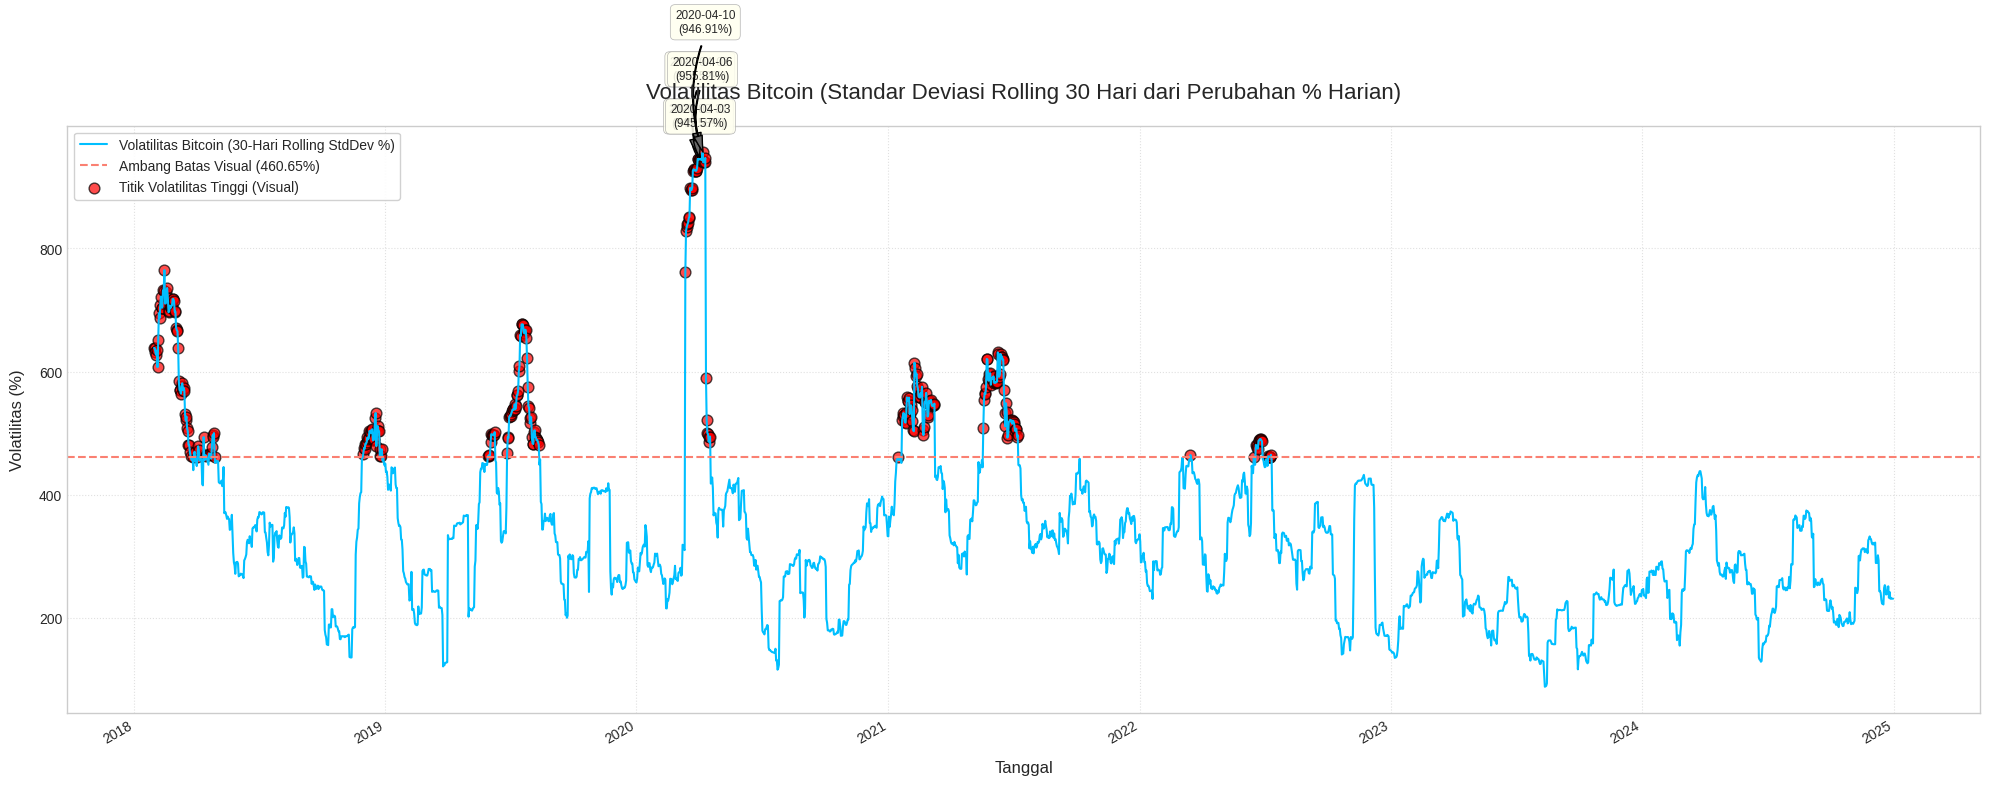

In [ ]:
df_analysis = df_merged.copy()


# Hitung perubahan persentase harga harian
df_analysis['Change %'] = (df_analysis['Price'] - df_analysis['Open']) / df_analysis['Open'] * 100

# Hitung volatilitas sebagai standar deviasi rolling 30 hari dari 'Change %'
df_analysis['Volatility'] = df_analysis['Change %'].rolling(window=30).std() * 100

# Hapus baris dengan NaN yang dihasilkan oleh rolling window
df_analysis.dropna(subset=['Volatility'], inplace=True)

# Tentukan ambang batas untuk periode volatilitas tinggi (untuk analisis penyebab)
avg_volatility = df_analysis['Volatility'].mean()
std_volatility = df_analysis['Volatility'].std()
high_volatility_threshold_cause_analysis = avg_volatility + 2 * std_volatility

# Identifikasi periode volatilitas tinggi untuk analisis penyebab
high_volatility_periods = df_analysis[df_analysis['Volatility'] > high_volatility_threshold_cause_analysis]

# Tentukan kolom Bitcoin dan kolom indikator makroekonomi
btc_cols = ['Tanggal', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
macro_cols = [col for col in df_analysis.columns if col not in btc_cols and col != 'Volatility']

# Siapkan DataFrame untuk analisis perubahan indikator makro
df_changes = df_analysis[['Tanggal'] + macro_cols].copy()
df_changes_shifted = df_changes.copy()
df_changes_shifted[macro_cols] = df_changes_shifted[macro_cols].shift(1)

# Analisis penyebab volatilitas tinggi
cause_analysis = {}
for date_hv in high_volatility_periods['Tanggal']:
    window_start = pd.to_datetime(date_hv) - pd.DateOffset(days=10)
    window_end = pd.to_datetime(date_hv)
    mask = (df_changes['Tanggal'] >= window_start) & (df_changes['Tanggal'] <= window_end)
    current_window = df_changes.loc[mask].reset_index(drop=True)
    previous_window = df_changes_shifted.loc[mask].reset_index(drop=True)

    significant_changes_for_date = []
    for i in range(len(current_window)):
        row_now = current_window.loc[i]
        row_prev = previous_window.loc[i]
        for col in macro_cols:
            val_now = row_now[col]
            val_prev = row_prev[col]
            if pd.notna(val_now) and pd.notna(val_prev):
                delta = val_now - val_prev
                if delta != 0:
                    significant_changes_for_date.append({
                        'Tanggal Perubahan': row_now['Tanggal'],
                        'Indikator': col,
                        'Dari': val_prev,
                        'Ke': val_now,
                        'Perubahan': delta
                    })

    if significant_changes_for_date:
        cause_analysis[date_hv] = significant_changes_for_date

def visualize_volatility(df, volatility_col='Volatility', date_col='Tanggal', top_n=5):
    """
    Memvisualisasikan volatilitas Bitcoin dan menyorot titik-titik volatilitas tinggi.
    Pembaruan: Logika anotasi yang ditingkatkan untuk mengurangi tumpukan.

    Args:
        df (pd.DataFrame): DataFrame yang berisi data tanggal dan volatilitas.
        volatility_col (str): Nama kolom yang berisi data volatilitas.
        date_col (str): Nama kolom yang berisi data tanggal.
        top_n (int): Jumlah titik volatilitas tertinggi yang akan diberi anotasi.
    """
    plt.style.use('seaborn-v0_8-whitegrid')

    viz_high_volatility_threshold = df[volatility_col].mean() + df[volatility_col].std()
    df_high_viz = df[df[volatility_col] > viz_high_volatility_threshold]

    plt.figure(figsize=(20, 8)) # Sedikit menambah tinggi figure

    plt.plot(df[date_col], df[volatility_col], label='Volatilitas Bitcoin (30-Hari Rolling StdDev %)', color='deepskyblue', linewidth=1.5)
    plt.axhline(viz_high_volatility_threshold, color='salmon', linestyle='--', linewidth=1.5, label=f'Ambang Batas Visual ({viz_high_volatility_threshold:.2f}%)')
    plt.scatter(df_high_viz[date_col], df_high_viz[volatility_col], color='red', s=60, label='Titik Volatilitas Tinggi (Visual)', alpha=0.7, edgecolors='black')

    # Anotasi hanya pada N titik tertinggi dari seluruh periode data
    top_overall_high_points = df.sort_values(by=volatility_col, ascending=False).head(top_n)

    # Urutkan N titik tertinggi berdasarkan tanggal untuk penanganan tumpukan yang lebih baik
    if not top_overall_high_points.empty:
        top_overall_high_points = top_overall_high_points.sort_values(by=date_col)

        # Simpan posisi anotasi sebelumnya untuk menghindari tumpukan
        last_annotated_date = None
        last_y_pos = 0

        vertical_offset_base = df[volatility_col].max() * 0.05
        vertical_offset_increment = df[volatility_col].max() * 0.08 # Penyesuaian untuk tumpukan

        for i, (_, row) in enumerate(top_overall_high_points.iterrows()):
            date_str = row[date_col].strftime('%Y-%m-%d')
            vol_val = row[volatility_col]

            current_date = row[date_col]

            # Tentukan posisi teks anotasi
            x_text_pos = current_date
            y_text_pos = vol_val + vertical_offset_base

            # Heuristik untuk menghindari tumpukan dengan anotasi sebelumnya
            if last_annotated_date is not None:
                # Jika tanggal saat ini sangat dekat dengan tanggal anotasi terakhir
                # dan posisi y juga akan dekat, naikkan posisi y saat ini.
                days_diff = (current_date - last_annotated_date).days
                if days_diff < 15 and abs(y_text_pos - last_y_pos) < vertical_offset_increment : # Jika dekat (misal < 15 hari)
                    y_text_pos = last_y_pos + vertical_offset_increment # Naikkan lebih tinggi dari sebelumnya
                elif days_diff < 45 and abs(y_text_pos - last_y_pos) < vertical_offset_base:
                     y_text_pos = vol_val + vertical_offset_base + (vertical_offset_increment * (i%2)) # Alternatif sedikit


            plt.annotate(f"{date_str}\n({vol_val:.2f}%)",
                         xy=(current_date, vol_val),
                         xytext=(x_text_pos, y_text_pos),
                         textcoords='data',
                         arrowprops=dict(facecolor='dimgray', shrink=0.05, width=0.5, headwidth=6, connectionstyle="arc3,rad=0.2"),
                         fontsize=8.5, # Ukuran font disesuaikan
                         ha='center',
                         va='bottom', # Vertical alignment
                         bbox=dict(boxstyle="round,pad=0.4", fc="ivory", ec="darkgray", lw=0.5, alpha=0.88)) # Styling bbox

            last_annotated_date = current_date
            last_y_pos = y_text_pos


    plt.title("Volatilitas Bitcoin (Standar Deviasi Rolling 30 Hari dari Perubahan % Harian)", fontsize=16, pad=20)
    plt.xlabel("Tanggal", fontsize=12, labelpad=10)
    plt.ylabel("Volatilitas (%)", fontsize=12, labelpad=10)
    plt.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.xticks(rotation=30, ha='right') # Rotasi sedikit dikurangi untuk potensi kejelasan
    plt.tight_layout()
    plt.show()

# --- Output Hasil Akhir dan Visualisasi ---
if not df_analysis.empty:
    print("\n📊 Analisis Penyebab Potensial untuk Periode Volatilitas Tinggi:")
    if cause_analysis:
        # Urutkan cause_analysis berdasarkan tanggal kejadian volatilitas tinggi
        sorted_cause_analysis = sorted(cause_analysis.items(), key=lambda item: pd.to_datetime(item[0]))
        for date_event, changes in sorted_cause_analysis:
            vol_value_on_event_date = df_analysis[df_analysis['Tanggal'] == date_event]['Volatility'].iloc[0]
            print(f"\n📌 Tanggal Volatilitas Tinggi: {pd.to_datetime(date_event).strftime('%Y-%m-%d')} (Vol: {vol_value_on_event_date:.2f}%)")
            sorted_changes = sorted(changes, key=lambda x: (x['Tanggal Perubahan'], x['Indikator']))
            for change in sorted_changes:
                tgl_perubahan_str = change['Tanggal Perubahan'].strftime('%Y-%m-%d')
                indikator = change['Indikator']
                dari = change['Dari']
                ke = change['Ke']
                delta = change['Perubahan']
                print(f"  - [{tgl_perubahan_str}] {indikator}: dari {dari:.2f} ke {ke:.2f} (Perubahan: {delta:+.2f})")
    else:
        print("Tidak ditemukan periode volatilitas tinggi berdasarkan ambang batas untuk analisis penyebab, atau tidak ada perubahan signifikan pada indikator makro yang terdeteksi.")

    all_records = []
    if cause_analysis:
        for date_event, events in cause_analysis.items():
            for event in events:
                all_records.append({
                    'Tanggal Volatilitas': date_event,
                    'Tanggal Perubahan Indikator': event['Tanggal Perubahan'],
                    'Indikator Makro': event['Indikator'],
                    'Nilai Awal': event['Dari'],
                    'Nilai Akhir': event['Ke'],
                    'Perubahan Nilai': event['Perubahan']
                })
        df_event_causes = pd.DataFrame(all_records)
        if not df_event_causes.empty:
            df_event_causes = df_event_causes.sort_values(by=['Tanggal Volatilitas', 'Tanggal Perubahan Indikator'])
            print("\n📋 DataFrame Hasil Analisis Penyebab (Contoh):")
            print(df_event_causes.head().to_string()) # Menampilkan beberapa baris dengan format lebih baik
            # df_event_causes.to_csv("analisis_penyebab_volatilitas_update.csv", index=False)

    visualize_volatility(df_analysis, top_n=5)

else:
    print("DataFrame analisis kosong. Periksa pemuatan data dan perhitungan rolling window.")



In [ ]:
df_event_causes

,Tanggal Volatilitas,Tanggal Perubahan Indikator,Indikator Makro,Nilai Awal,Nilai Akhir,Perubahan Nilai
0,2018-01-31,2018-01-31,EUR_German Unemployment Change,-29000.0,-25000.0,4000.0
1,2018-01-31,2018-01-31,EUR_German Unemployment Rate,5.5,5.4,-0.1
2,2018-01-31,2018-01-31,USD_ADP Nonfarm Employment Change,250000.0,234000.0,-16000.0
3,2018-02-01,2018-01-31,EUR_German Unemployment Change,-29000.0,-25000.0,4000.0
4,2018-02-01,2018-01-31,EUR_German Unemployment Rate,5.5,5.4,-0.1
...,...,...,...,...,...,...
1420,2021-06-17,2021-06-16,GBP_CPIH (YoY),1.6,2.1,0.5
1421,2021-06-17,2021-06-16,CNY_Chinese Unemployment Rate,5.3,5.2,-0.1
1422,2021-06-17,2021-06-17,USD_Continuing Jobless Claims,3499000.0,3518000.0,19000.0
1423,2021-06-17,2021-06-17,USD_Initial Jobless Claims,376000.0,412000.0,36000.0


### - Menganalisis penyebab volatilitas tinggi dan mengidentifikasi indikator makroekonomi yang berpengaruh.


In [ ]:
# Indikator yang paling sering muncul sebagai penyebab volatilitas tinggi
top_causes = df_event_causes['Indikator Makro'].value_counts().reset_index() # Changed 'Indikator' to 'Indikator Makro'
top_causes.columns = ['Indikator Makro', 'Frekuensi'] # Changed 'Indikator' to 'Indikator Makro'

# Tanggal dengan volatilitas tertinggi
max_vol_row = df_analysis.loc[df_analysis['Volatility'].idxmax()]
max_vol_date = max_vol_row['Tanggal']
max_vol_value = max_vol_row['Volatility']

# Event pada tanggal itu
events_on_max_vol = df_event_causes[df_event_causes['Tanggal Volatilitas'] == max_vol_date]

# Output
print(f"\n📈 Tanggal dengan volatilitas tertinggi: {max_vol_date.date()} dengan nilai {max_vol_value:.2f}%")
print("\n📌 Event makroekonomi yang terjadi sekitar tanggal tersebut:")
for _, row in events_on_max_vol.iterrows():
    # Use 'Tanggal Perubahan Indikator' instead of 'Tanggal Perubahan'
    # Use correct column names: 'Nilai Awal', 'Nilai Akhir', 'Perubahan Nilai'
    print(f" - {row['Tanggal Perubahan Indikator'].date()} | {row['Indikator Makro']}: dari {row['Nilai Awal']:.2f} ke {row['Nilai Akhir']:.2f} (Perubahan: {row['Perubahan Nilai']:+.2f})")

print("\n Rangking Indikator Makroekonomi yang Muncul Saat Volatilitas Tinggi:")
print(top_causes)


# Menghitung perubahan volatilitas selama periode 1 minggu (7 hari)
df_analysis['Volatility Change'] = df_analysis['Volatility'].pct_change(periods=7) * 100

# Menentukan threshold sebagai persentil ke-90 dari volatilitas
threshold = df_analysis['Volatility'].quantile(0.9)
print(f"📊 Threshold volatilitas tinggi (90th percentile): {threshold:.2f}%")

# Sekarang baru aman digunakan
high_volatility_periods = df_analysis[df_analysis['Volatility'] > threshold]

# 1. Menghitung periode volatilitas tinggi (misalnya dengan threshold tertentu)
high_volatility_periods = df_analysis[df_analysis['Volatility'] > threshold]

# 2. Mengambil event-event makroekonomi yang terjadi pada periode volatilitas tinggi
df_event_causes_high_vol = df_event_causes[df_event_causes['Tanggal Volatilitas'].isin(high_volatility_periods['Tanggal'])]

# 3. Mengidentifikasi perubahan volatilitas yang besar terkait perubahan indikator
df_event_causes_high_vol['Abs Delta'] = df_event_causes_high_vol['Perubahan Nilai'].abs() # Changed 'Delta' to 'Perubahan Nilai'

# 4. Tentukan periode di mana perubahan volatilitas terjadi dan ambil perubahan terbesar
df_event_causes_high_vol['Volatility Change'] = df_event_causes_high_vol.apply(
    lambda row: df_analysis.loc[df_analysis['Tanggal'] == row['Tanggal Volatilitas'], 'Volatility Change'].values[0]
                if len(df_analysis.loc[df_analysis['Tanggal'] == row['Tanggal Volatilitas']]) > 0 else 0, axis=1)

# 5. Ambil perubahan terbesar berdasarkan volatilitas
most_impactful_vol_changes = df_event_causes_high_vol.sort_values(by='Volatility Change', ascending=False).head() # Call the head() function

# 6. Tampilkan hasil perubahan volatilitas yang paling berpengaruh
print("\n💥 10 Perubahan Volatilitas Terbesar Setelah Perubahan Indikator Makroekonomi:")
for _, row in most_impactful_vol_changes.iterrows():
    print(f" - {row['Tanggal Volatilitas'].date()} | {row['Indikator Makro']}: dari {row['Nilai Awal']:.2f} ke {row['Nilai Akhir']:.2f} (Perubahan Volatilitas: {row['Volatility Change']:+.2f}%)")  # Changed 'Dari' and 'Ke'

# 7. Indikator makroekonomi yang paling berpengaruh terhadap perubahan volatilitas
top_impactful_vol_indicators = df_event_causes_high_vol.groupby('Indikator Makro').agg({'Volatility Change': 'sum'}).reset_index()
top_impactful_vol_indicators = top_impactful_vol_indicators.sort_values(by='Volatility Change', ascending=False).head(10)

print("\n🔥 10 Indikator Makroekonomi yang Paling Berpengaruh pada Perubahan Volatilitas:")
for _, row in top_impactful_vol_indicators.iterrows():
    print(f" - {row['Indikator Makro']}: Perubahan Total Volatilitas: {row['Volatility Change']:.2f}")


📈 Tanggal dengan volatilitas tertinggi: 2020-04-06 dengan nilai 955.81%

📌 Event makroekonomi yang terjadi sekitar tanggal tersebut:
 - 2020-03-27 | JPY_Tokyo Core CPI (YoY): dari 0.50 ke 0.40 (Perubahan: -0.10)
 - 2020-03-27 | USD_Core PCE Price Index (MoM): dari 0.10 ke 0.20 (Perubahan: +0.10)
 - 2020-03-27 | USD_Core PCE Price Index (YoY): dari 1.60 ke 1.80 (Perubahan: +0.20)
 - 2020-03-27 | USD_PCE Price index (YoY): dari 1.70 ke 1.80 (Perubahan: +0.10)
 - 2020-03-30 | EUR_German CPI (MoM): dari 0.40 ke 0.10 (Perubahan: -0.30)
 - 2020-03-30 | EUR_German CPI (YoY): dari 1.70 ke 1.40 (Perubahan: -0.30)
 - 2020-03-31 | EUR_German Unemployment Change: dari -10000.00 ke 1000.00 (Perubahan: +11000.00)
 - 2020-03-31 | GBP_GDP (YoY): dari 0.60 ke 1.10 (Perubahan: +0.50)
 - 2020-03-31 | CNY_Manufacturing PMI: dari 35.70 ke 52.00 (Perubahan: +16.30)
 - 2020-03-31 | CNY_Non-Manufacturing PMI: dari 29.60 ke 52.30 (Perubahan: +22.70)
 - 2020-03-31 | USD_Chicago PMI: dari 49.00 ke 47.80 (Peruba

##c. Analisis Perubahan Harga Setelah Suku Bunga Berubah

### - Menganalisis dampak perubahan suku bunga terhadap harga Bitcoin dalam jangka waktu tertentu.


In [ ]:
def analyze_bitcoin_after_event(bitcoin_data, event_column, target_column='Price', lookback_days=3):
    """
    Menganalisis dampak perubahan nilai event terhadap harga Bitcoin beberapa hari ke depan.
    Mengembalikan DataFrame berisi waktu perubahan event dan perubahan harga BTC setelahnya.
    """
    bitcoin_data = bitcoin_data.sort_values('Tanggal')
    bitcoin_data = bitcoin_data.reset_index(drop=True)

    results = []
    for i in range(1, len(bitcoin_data) - lookback_days):
        prev_val = bitcoin_data.loc[i - 1, event_column]
        curr_val = bitcoin_data.loc[i, event_column]

        # Deteksi perubahan nilai eventttt
        if pd.notna(prev_val) and pd.notna(curr_val) and prev_val != curr_val:
            harga_awal = bitcoin_data.loc[i, target_column]
            harga_akhir = bitcoin_data.loc[i + lookback_days, target_column]

            persentase_perubahan = ((harga_akhir - harga_awal) / harga_awal) * 100

            arah = 'Naik' if curr_val > prev_val else 'Turun'

            results.append({
                'Tanggal Perubahan Event': bitcoin_data.loc[i, 'Tanggal'],
                'Nilai Sebelumnya': prev_val,
                'Nilai Sekarang': curr_val,
                'Arah Perubahan': arah,
                f'Persentase Perubahan Harga Bitcoin ({lookback_days} Hari)': persentase_perubahan
            })

    return pd.DataFrame(results)

def visualize_price_with_event_changes(price_data, event_column, price_column='Price', date_column='Tanggal'):
    price_data = price_data.copy()
    price_data = price_data.sort_values(date_column).reset_index(drop=True)

    # Deteksi perubahan nilai event
    change_mask = price_data[event_column].diff().fillna(0) != 0

    # Plot harga
    plt.figure(figsize=(14, 6))
    plt.plot(price_data[date_column], price_data[price_column], label='Harga Bitcoin', color='blue')

    # Tandai titik perubahan
    plt.scatter(
        price_data.loc[change_mask, date_column],
        price_data.loc[change_mask, price_column],
        color='red',
        label='Perubahan Event',
        marker='o'
    )

    plt.xlabel('Tanggal')
    plt.ylabel('Harga Bitcoin')
    plt.title(f'Harga Bitcoin dan Perubahan pada "{event_column}"')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


--- Analisis Perubahan Harga Bitcoin (2 Hari Setelah Perubahan 'USD_Fed Interest Rate Decision') ---

+---------------------+--------------------+------------------+------------------+--------------------------------+-----------------------------------+-----------------------------------------------+
| Tanggal Perubahan   |   Nilai Sebelumnya |   Nilai Saat Ini | Arah Perubahan   |   Harga Bitcoin Saat Perubahan |   Harga Bitcoin 2 Hari Setelahnya |   Persentase Perubahan Harga Bitcoin (2 Hari) |
+=====================+====================+==================+==================+================================+===================================+===============================================+
| 2018-03-22 00:00:00 |               1.50 |             1.75 | Naik             |                        8726.20 |                           8547.40 |                                         -2.05 |
+---------------------+--------------------+------------------+------------------+---------------

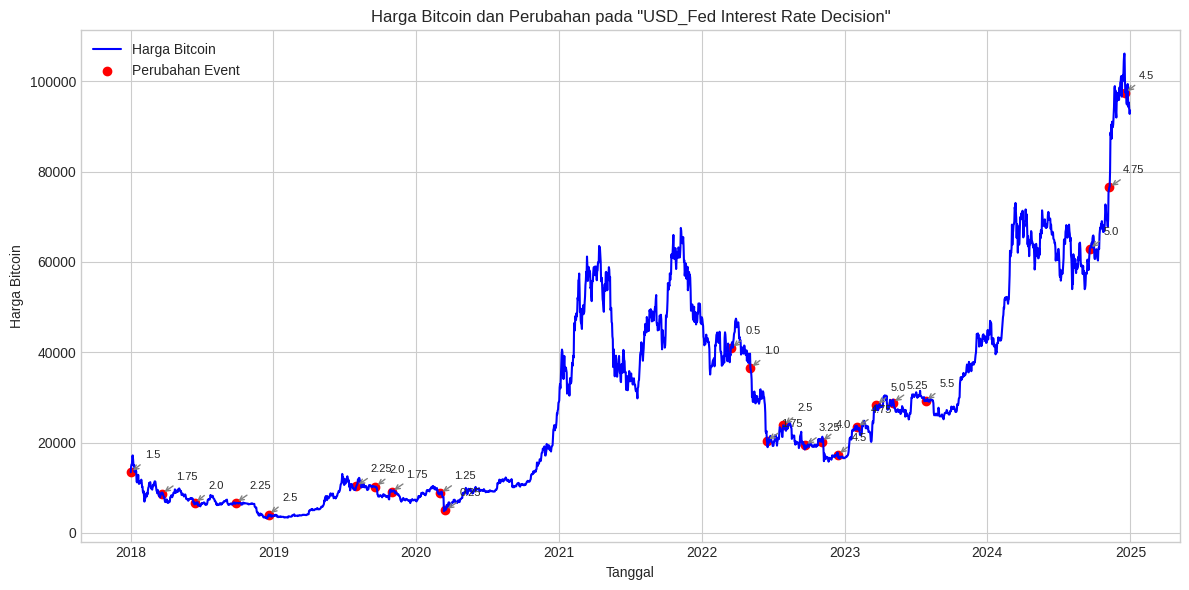

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


def analyze_bitcoin_after_event(bitcoin_price_history_df, event_column, lookback_days=3):
    """
    Menganalisis persentase perubahan harga Bitcoin setelah perubahan nilai pada kolom tertentu.

    Args:
        bitcoin_price_history_df (pd.DataFrame): DataFrame berisi data harga Bitcoin dan kolom event (BELUM dinormalisasi).
        event_column (str): Nama kolom yang akan dianalisis perubahannya.
        lookback_days (int): Jangka waktu (dalam hari kalender) setelah perubahan event.

    Returns:
        pd.DataFrame: DataFrame hasil analisis perubahan event dan dampaknya ke harga Bitcoin.
    """
    # Pastikan kolom tanggal benar dan urut
    bitcoin_price_history_df['Tanggal'] = pd.to_datetime(bitcoin_price_history_df['Tanggal'])
    bitcoin_price_history_df = bitcoin_price_history_df.sort_values(by='Tanggal').drop_duplicates(subset='Tanggal')
    bitcoin_price_history_df = bitcoin_price_history_df.set_index('Tanggal')

    event_changes = []
    previous_value = None

    for index, row in bitcoin_price_history_df.iterrows():
        current_value = row[event_column]

        # Deteksi perubahan nilai event
        if previous_value is not None and current_value != previous_value:
            change_info = {
                'Tanggal Perubahan': index,
                'Nilai Sebelumnya': previous_value,
                'Nilai Saat Ini': current_value,
            }

            # Deteksi arah perubahan
            if isinstance(current_value, (int, float)) and isinstance(previous_value, (int, float)):
                if current_value > previous_value:
                    change_info['Arah Perubahan'] = 'Naik'
                elif current_value < previous_value:
                    change_info['Arah Perubahan'] = 'Turun'
                else:
                    change_info['Arah Perubahan'] = 'Tidak Berubah (Error)'
            else:
                change_info['Arah Perubahan'] = 'Berubah'

            price_before = row['Price']
            future_date = index + pd.Timedelta(days=lookback_days)

            if future_date in bitcoin_price_history_df.index:
                price_after = bitcoin_price_history_df.loc[future_date, 'Price']
                percentage_change = ((price_after - price_before) / price_before) * 100

                change_info['Harga Bitcoin Saat Perubahan'] = price_before
                change_info[f'Harga Bitcoin {lookback_days} Hari Setelahnya'] = price_after
                change_info[f'Persentase Perubahan Harga Bitcoin ({lookback_days} Hari)'] = percentage_change
                event_changes.append(change_info)

        previous_value = current_value

    return pd.DataFrame(event_changes)


from tabulate import tabulate

def display_event_analysis_results(event_analysis_results_df, lookback_days=3, event_column='Event'):
    """Menampilkan hasil analisis perubahan event dalam format tabel rapi."""
    if event_analysis_results_df.empty:
        print(f"Tidak ada perubahan pada kolom '{event_column}' terdeteksi.")
        return

    print(f"\n--- Analisis Perubahan Harga Bitcoin ({lookback_days} Hari Setelah Perubahan '{event_column}') ---\n")

    print(tabulate(
        event_analysis_results_df,
        headers='keys',
        tablefmt='grid',
        showindex=False,
        floatfmt=".2f"  # format untuk angka desimal
    ))

    print("\n--- Ringkasan ---")
    if 'Arah Perubahan' in event_analysis_results_df.columns:
        naik = event_analysis_results_df[event_analysis_results_df['Arah Perubahan'] == 'Naik']
        turun = event_analysis_results_df[event_analysis_results_df['Arah Perubahan'] == 'Turun']

        if not naik.empty:
            mean_naik = naik[f'Persentase Perubahan Harga Bitcoin ({lookback_days} Hari)'].mean()
            print(f"Rata-rata perubahan BTC setelah '{event_column}' naik: {mean_naik:.2f}%")
        else:
            print(f"Tidak ada kasus kenaikan pada '{event_column}'.")

        if not turun.empty:
            mean_turun = turun[f'Persentase Perubahan Harga Bitcoin ({lookback_days} Hari)'].mean()
            print(f"Rata-rata perubahan BTC setelah '{event_column}' turun: {mean_turun:.2f}%")
        else:
            print(f"Tidak ada kasus penurunan pada '{event_column}'.")

def visualize_price_with_event_changes(price_visualization_df, event_column):
    """Visualisasi harga Bitcoin dengan penanda titik perubahan event."""
    price_visualization_df = price_visualization_df.sort_values(by='Tanggal')
    price_visualization_df = price_visualization_df.drop_duplicates(subset='Tanggal').set_index('Tanggal')

    plt.figure(figsize=(12, 6))
    plt.plot(price_visualization_df.index, price_visualization_df['Price'], label='Harga Bitcoin', color='blue')

    change_dates = price_visualization_df[price_visualization_df[event_column].diff() != 0].index
    plt.scatter(change_dates, price_visualization_df.loc[change_dates, 'Price'], color='red', label='Perubahan Event')

    for date in change_dates:
        event_val = price_visualization_df.loc[date, event_column]
        plt.annotate(f'{event_val}', xy=(date, price_visualization_df.loc[date, 'Price']), xytext=(10, 10),
                     textcoords='offset points', arrowprops=dict(arrowstyle='->', color='gray'), fontsize=8)

    plt.title(f'Harga Bitcoin dan Perubahan pada "{event_column}"')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Bitcoin')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

bitcoin_price_history_df = df_merged.copy()
kolom_yang_dianalisis = 'USD_Fed Interest Rate Decision'
jangka_waktu = 2

event_analysis_results_df = analyze_bitcoin_after_event(bitcoin_price_history_df, kolom_yang_dianalisis, lookback_days=jangka_waktu)
display_event_analysis_results(event_analysis_results_df, jangka_waktu, kolom_yang_dianalisis)
visualize_price_with_event_changes(bitcoin_price_history_df, kolom_yang_dianalisis)

##d. Analisis Korelasi Lag

### - Menghitung korelasi lag antara perubahan event makroekonomi (suku bunga) dan perubahan harga Bitcoin.



--- Tabel Korelasi Lag (Hanya Hari Event Aktual) ---
   Lag (Hari)  Korelasi USD_Fed Interest Rate Decision vs Price
0           1                                         -0.133786
1           2                                         -0.327703
2           3                                         -0.193280
3           4                                         -0.155795
4           5                                         -0.211306
5           6                                         -0.070912
6           7                                         -0.032854
7           8                                          0.070782
8           9                                          0.286733
9          10                                          0.000095


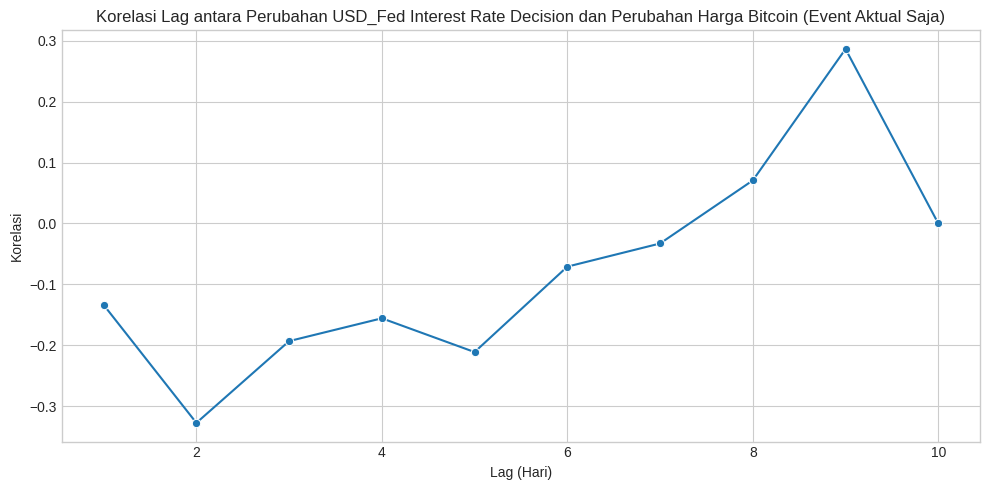

In [ ]:
def korelasi_lag_event_vs_price(df, event_column, max_lag=10):
    df = df.copy()
    df['Tanggal'] = pd.to_datetime(df['Tanggal'])
    df = df.sort_values('Tanggal')
    df.set_index('Tanggal', inplace=True)

    # Hitung perubahan harian harga
    df['Price_Change'] = df['Price'].diff()

    # Hitung perubahan event (misal: suku bunga)
    df['Event_Change'] = df[event_column].diff()

    # Ambil hanya baris saat event benar-benar berubah (misalnya pengumuman suku bunga baru)
    event_change_days = df[df['Event_Change'].notna() & (df['Event_Change'] != 0)]

    hasil = []

    for lag in range(1, max_lag + 1):
        korelasi_list = []

        for tanggal_event in event_change_days.index:
            tanggal_target = tanggal_event + pd.Timedelta(days=lag)
            if tanggal_target in df.index:
                korelasi_list.append((
                    df.loc[tanggal_event, 'Event_Change'],  # perubahan event
                    df.loc[tanggal_target, 'Price_Change']  # perubahan harga setelah lag hari
                ))

        if korelasi_list:
            event_changes, price_changes = zip(*korelasi_list)
            korelasi = pd.Series(event_changes).corr(pd.Series(price_changes))
        else:
            korelasi = None

        hasil.append({'Lag (Hari)': lag, f'Korelasi {event_column} vs Price': korelasi})

    return pd.DataFrame(hasil)

def plot_korelasi_lag(df_korelasi, event_column):
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_korelasi, x='Lag (Hari)', y=f'Korelasi {event_column} vs Price', marker='o')
    plt.title(f'Korelasi Lag antara Perubahan {event_column} dan Perubahan Harga Bitcoin (Event Aktual Saja)')
    plt.xlabel('Lag (Hari)')
    plt.ylabel('Korelasi')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
hasil_korelasi = korelasi_lag_event_vs_price(df_merged, 'USD_Fed Interest Rate Decision', max_lag=10)
print("\n--- Tabel Korelasi Lag (Hanya Hari Event Aktual) ---")
print(hasil_korelasi)
plot_korelasi_lag(hasil_korelasi, 'USD_Fed Interest Rate Decision')

##e. Analisis ACF dan PACF:


### - Menganalisis autokorelasi dan partial autokorelasi harga Bitcoin untuk mengidentifikasi pola time series.


<Figure size 1000x600 with 0 Axes>

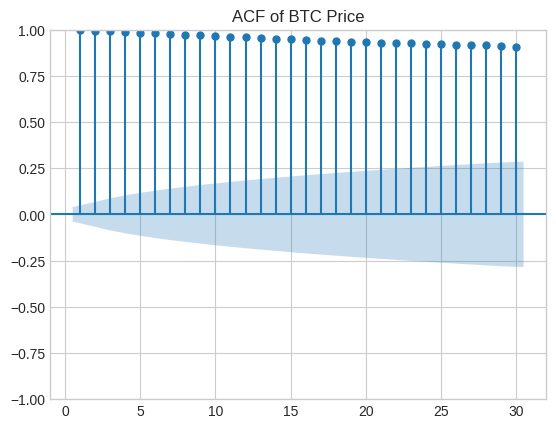

<Figure size 1000x600 with 0 Axes>

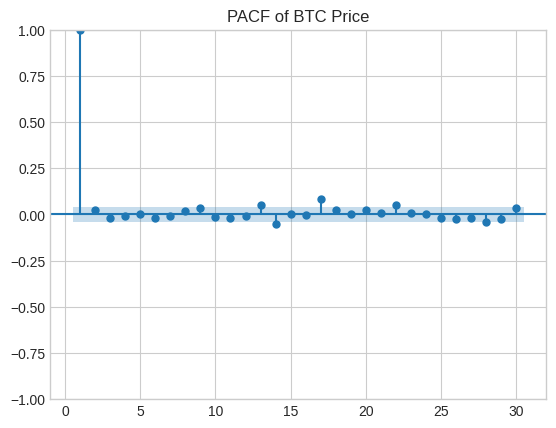

ACF Values (first 30 lags): [1.         0.99643391 0.99305764 0.98954538 0.98598504 0.98246415
 0.97880198 0.97508576 0.9714912  0.96812617 0.96466821 0.9611026
 0.9574857  0.95423885 0.95062865 0.94709484 0.94351321 0.94052461
 0.93772026 0.93495035 0.93236955 0.92980684 0.92766691 0.92558936
 0.92353621 0.92129585 0.91893812 0.91646137 0.91370706 0.91074595
 0.90804067]
PACF Values (first 30 lags): [ 1.          0.99682916  0.02801945 -0.02251929 -0.0108289   0.00421336
 -0.02366125 -0.0121281   0.01751083  0.0363669  -0.01543458 -0.02150641
 -0.01061132  0.05716134 -0.05806161  0.00447323 -0.00505101  0.09603855
  0.0278765   0.0012494   0.0287284   0.00723003  0.0568562   0.00782152
  0.0046664  -0.02173314 -0.02869295 -0.02267177 -0.05045609 -0.02498386
  0.03718172]


In [ ]:
# Salinan df_merged tanpa perubahan harga
df_btc_acf_pacf = df_merged.copy()

# Menghapus nilai NaN pada kolom 'Price'
df_btc_acf_pacf_clean = df_btc_acf_pacf.dropna(subset=['Price'])

# Memeriksa dan menghapus outlier dengan Z-Score
df_btc_acf_pacf_clean['Z_Score'] = zscore(df_btc_acf_pacf_clean['Price'])
df_btc_acf_pacf_clean = df_btc_acf_pacf_clean[df_btc_acf_pacf_clean['Z_Score'].abs() <= 3]

# Visualisasi ACF dan PACF menggunakan harga asli
plt.figure(figsize=(10, 6))
plot_acf(df_btc_acf_pacf_clean['Price'], lags=30, title="ACF of BTC Price", zero=False)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(df_btc_acf_pacf_clean['Price'], lags=30, title="PACF of BTC Price", zero=False, method='ywm')
plt.show()

# Perhitungan ACF dan PACF untuk 30 lag pertama
acf_values = acf(df_btc_acf_pacf_clean['Price'], nlags=30)
pacf_values = pacf(df_btc_acf_pacf_clean['Price'], nlags=30)

# Print nilai ACF dan PACF
print("ACF Values (first 30 lags):", acf_values)
print("PACF Values (first 30 lags):", pacf_values)

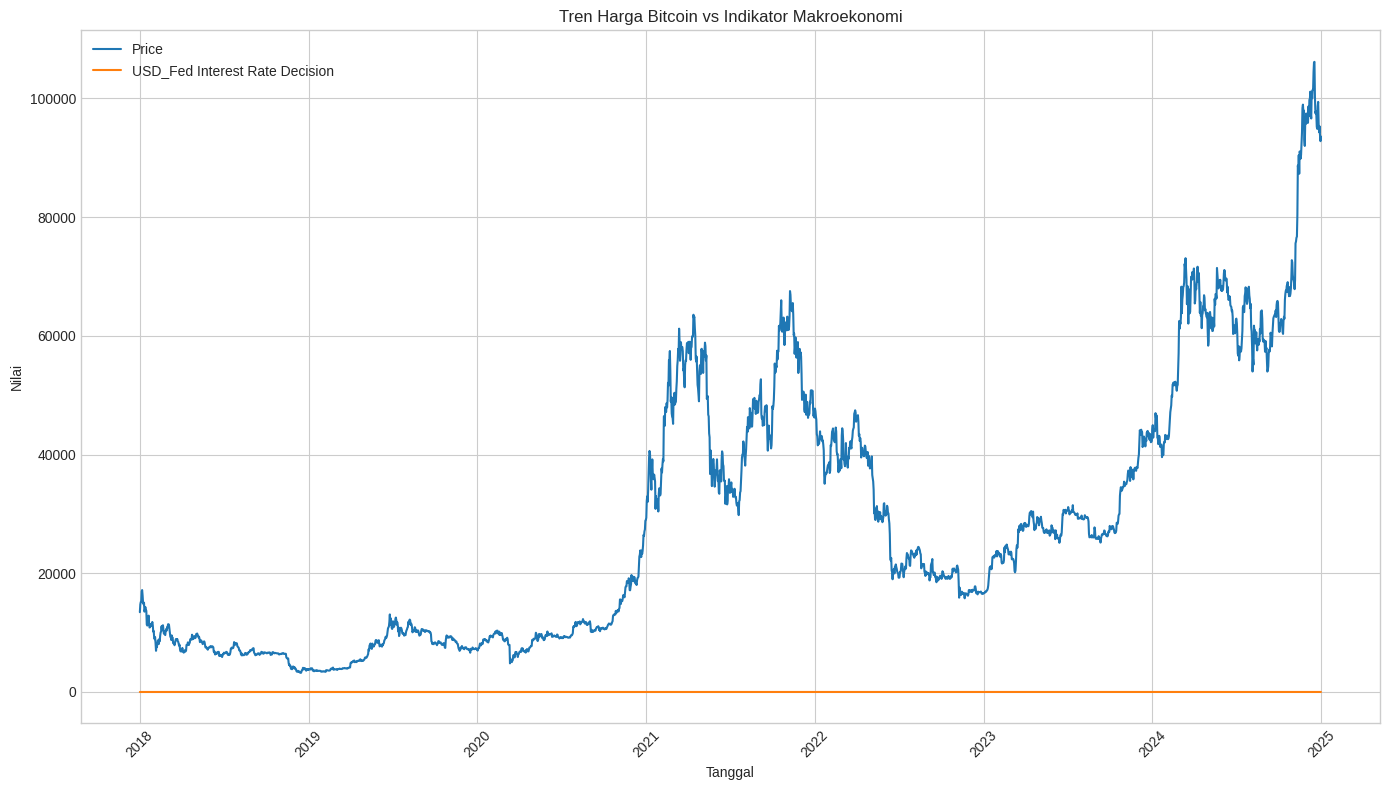

In [ ]:
# This ensures the original df_merged is not modified
df_trend_analysis = df_merged.copy() # <-- Baris yang diminta

# Convert 'Tanggal' to datetime if it's not already on the copy
df_trend_analysis['Tanggal'] = pd.to_datetime(df_trend_analysis['Tanggal'])

# Set 'Tanggal' as the index for easier plotting on the copy
df_trend_analysis = df_trend_analysis.set_index('Tanggal')

# Select the columns you want to plot from the copied DataFrame
indicators = ['Price', 'USD_Fed Interest Rate Decision']  # Replace with your actual indicator columns
plot_df = df_trend_analysis[indicators] # Menggunakan df_trend_analysis

# Create the line plot
plt.figure(figsize=(14, 8))
for column in plot_df.columns:
    # Plotting using the index (Tanggal) and values from plot_df
    plt.plot(plot_df.index, plot_df[column], label=column)

plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.title('Tren Harga Bitcoin vs Indikator Makroekonomi')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

#Normalisasi Fitur dan Target
Melakukan normalisasi data pada fitur dan target menggunakan MinMaxScaler.


In [ ]:
# Pisahkan kembali kolom target dan fitur numerik
target_col = 'Price'
exclude_cols = ['Tanggal', target_col]
feature_cols = [col for col in df_merged.columns if col not in exclude_cols]

# Buat dua scaler: satu untuk fitur, satu untuk target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Simpan versi asli jika nanti dibutuhkan (untuk visualisasi atau denormalisasi)
df_original = df_merged.copy()

# Transform fitur
df_merged.loc[:, feature_cols] = scaler_features.fit_transform(df_merged[feature_cols])

# Transform target
df_merged.loc[:, [target_col]] = scaler_target.fit_transform(df_merged[[target_col]])

In [ ]:
joblib.dump(scaler_target, 'scaler_target.pkl')


['scaler_target.pkl']

In [ ]:
joblib.dump(scaler_features, 'scaler_features.pkl')

['scaler_features.pkl']

In [ ]:
df_merged

,Price,Open,High,Low,Vol.,Change %,Tanggal,EUR_German Unemployment Change,EUR_German Unemployment Rate,USD_ISM Manufacturing PMI,...,USD_Interest Rate Projection - 1st Yr,USD_Interest Rate Projection - 2nd Yr,USD_Interest Rate Projection - 3rd Yr,USD_Interest Rate Projection - Current,USD_Interest Rate Projection - Longer,CNY_PBoC Loan Prime Rate,CNY_Chinese GDP YTD (YoY),CNY_China Loan Prime Rate 5Y,USD_Atlanta Fed GDPNow,JPY_GDP Annualized (QoQ)
0,0.099273,0.103213,0.101362,0.094943,0.000017,0.618706,2018-01-01,0.133621,0.4,0.784483,...,0.36,0.500,0.766667,0.327273,0.166667,1.0,0.517928,1.0,0.366667,0.0
1,0.111995,0.099272,0.114553,0.095496,0.000031,0.834955,2018-01-02,0.133621,0.4,0.784483,...,0.36,0.500,0.766667,0.327273,0.166667,1.0,0.517928,1.0,0.366667,0.0
2,0.115906,0.111994,0.115781,0.111601,0.000024,0.715310,2018-01-03,0.133621,0.4,0.784483,...,0.36,0.500,0.766667,0.327273,0.166667,1.0,0.517928,1.0,0.366667,0.0
3,0.116134,0.115904,0.115531,0.108323,0.000025,0.671275,2018-01-04,0.133621,0.4,0.784483,...,0.36,0.500,0.766667,0.327273,0.166667,1.0,0.517928,1.0,0.366667,0.0
4,0.133379,0.116133,0.131900,0.114074,0.000032,0.868237,2018-01-05,0.133621,0.4,0.784483,...,0.36,0.500,0.766667,0.327273,0.166667,1.0,0.517928,1.0,0.366667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,0.884725,0.899290,0.895186,0.883749,0.000019,0.641918,2024-12-27,0.211207,0.8,0.297414,...,0.76,0.825,1.000000,0.781818,1.000000,0.0,0.462151,0.0,0.633333,0.0
2553,0.894526,0.884700,0.880333,0.890129,0.000007,0.686977,2024-12-28,0.211207,0.8,0.297414,...,0.76,0.825,1.000000,0.781818,1.000000,0.0,0.462151,0.0,0.633333,0.0
2554,0.879287,0.894492,0.876818,0.879383,0.000011,0.640553,2024-12-29,0.211207,0.8,0.297414,...,0.76,0.825,1.000000,0.781818,1.000000,0.0,0.462151,0.0,0.633333,0.0
2555,0.870187,0.879295,0.873207,0.864659,0.000025,0.651647,2024-12-30,0.211207,0.8,0.297414,...,0.76,0.825,1.000000,0.781818,1.000000,0.0,0.462151,0.0,0.633333,0.0


#Feature Engineering

##a. Analisis Korelasi dengan Target

### - Cek dan Buang Fitur Low Variance


In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Cek dan buang fitur dengan varians = 0
exclude_cols = ['Tanggal', 'Price']
feature_cols = [col for col in df_merged.select_dtypes(include=['float64', 'int64']).columns if col not in exclude_cols]

selector = VarianceThreshold(threshold=0.0)
selector.fit(df_merged[feature_cols])

# Ambil fitur yang lolos
selected_features = df_merged[feature_cols].columns[selector.get_support()]
dropped_features_var = list(set(feature_cols) - set(selected_features))

print("Fitur dengan varians 0 (dibuang):")
print(dropped_features_var)

# Update df_merged
df_merged = df_merged[exclude_cols + list(selected_features)]

Fitur dengan varians 0 (dibuang):
['JPY_GDP Annualized (QoQ)']


### Seleksi Fitur Berdasarkan Korelasi dengan Target

<ipython-input-36-8e1f7b228a34>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_correlation.values, y=feature_correlation.index, palette='coolwarm')


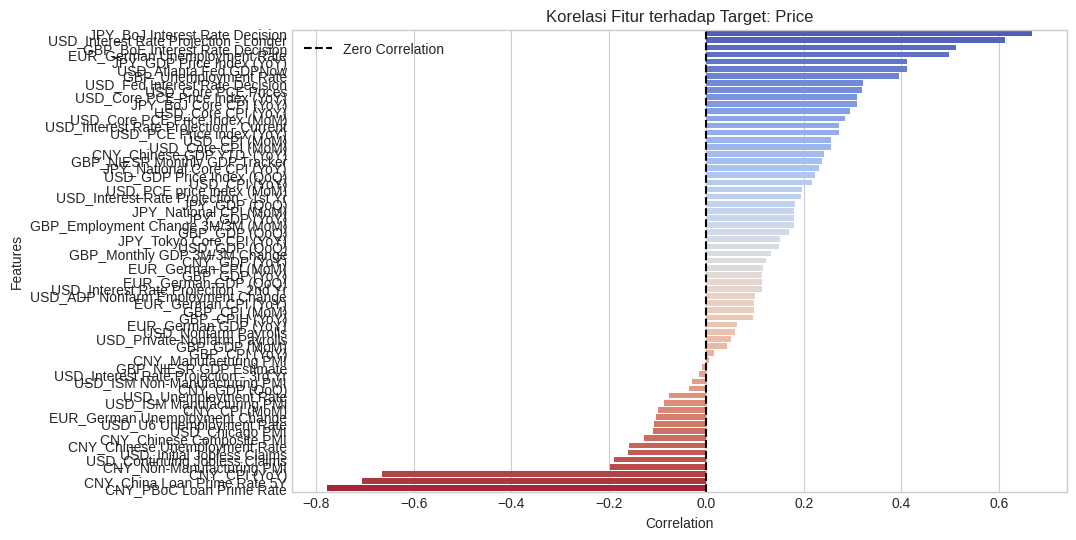

Adaptive Threshold: 0.3061
Fitur yang Berkorelasi Positif dan Dipilih:
['JPY_BoJ Interest Rate Decision', 'USD_Interest Rate Projection - Longer', 'GBP_BoE Interest Rate Decision', 'EUR_German Unemployment Rate', 'JPY_GDP Price Index (YoY)', 'USD_Atlanta Fed GDPNow', 'GBP_Unemployment Rate', 'USD_Fed Interest Rate Decision', 'USD_Core PCE Prices', 'USD_Core PCE Price Index (YoY)', 'JPY_BoJ Core CPI (YoY)']

Fitur yang Berkorelasi Negatif dan Dipilih:
['CNY_CPI (YoY)', 'CNY_China Loan Prime Rate 5Y', 'CNY_PBoC Loan Prime Rate']

Fitur yang Dihapus:
['USD_Core CPI (YoY)', 'USD_Core PCE Price Index (MoM)', 'USD_Interest Rate Projection - Current', 'USD_PCE Price index (YoY)', 'USD_CPI (MoM)', 'USD_Core CPI (MoM)', 'CNY_Chinese GDP YTD  (YoY)', 'GBP_NIESR Monthly GDP Tracker', 'JPY_National Core CPI (YoY)', 'USD_GDP Price Index (QoQ)', 'USD_CPI (YoY)', 'USD_PCE price index (MoM)', 'USD_Interest Rate Projection - 1st Yr', 'JPY_GDP (QoQ)', 'JPY_National CPI (MoM)', 'JPY_GDP (YoY)', 'GBP_Empl

In [ ]:
def analyze_target_correlation(df, target_col, exclude_cols=None, threshold_factor=0.5):
    if exclude_cols is None:
        exclude_cols = []

    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in feature_cols if col not in exclude_cols + [target_col]]

    correlations = df[feature_cols + [target_col]].corr()[target_col].drop(target_col)
    feature_correlation = correlations.sort_values(ascending=False)

    # Visualisasi
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_correlation.values, y=feature_correlation.index, palette='coolwarm')
    plt.axvline(0, color='black', linestyle='--', label='Zero Correlation')
    plt.title(f'Korelasi Fitur terhadap Target: {target_col}')
    plt.xlabel('Correlation')
    plt.ylabel('Features')
    plt.legend()
    plt.show()

    # Adaptive threshold
    mean_corr = feature_correlation.abs().mean()
    std_corr = feature_correlation.abs().std()
    adaptive_threshold = mean_corr + threshold_factor * std_corr
    print(f"Adaptive Threshold: {adaptive_threshold:.4f}")

    # Seleksi fitur
    selected_positive = feature_correlation[feature_correlation > adaptive_threshold].index.tolist()
    selected_negative = feature_correlation[feature_correlation < -adaptive_threshold].index.tolist()
    dropped_features = feature_correlation[(feature_correlation.abs() <= adaptive_threshold)].index.tolist()

    return selected_positive, selected_negative, dropped_features, feature_correlation

# Daftar kolom yang dikecualikan dari analisis korelasi
excluded_cols = ['Open', 'High', 'Low', 'Vol.', 'Change %']

selected_pos, selected_neg, dropped_corr, correlations = analyze_target_correlation(
    df_merged, target_col='Price', exclude_cols=excluded_cols, threshold_factor=0.5
)

print("Fitur yang Berkorelasi Positif dan Dipilih:")
print(selected_pos)
print("\nFitur yang Berkorelasi Negatif dan Dipilih:")
print(selected_neg)
print("\nFitur yang Dihapus:")
print(dropped_corr)

In [ ]:
# prompt: tampilkan hasil korelasi(nilai) dari code diatas ini

print("\n--- Tabel Korelasi Fitur terhadap Target ('Price') ---")
print(correlations.reset_index().rename(columns={'index': 'Fitur', 'Price': 'Korelasi'}).to_string())



--- Tabel Korelasi Fitur terhadap Target ('Price') ---
                                     Fitur  Korelasi
0           JPY_BoJ Interest Rate Decision  0.666899
1    USD_Interest Rate Projection - Longer  0.611951
2           GBP_BoE Interest Rate Decision  0.510899
3             EUR_German Unemployment Rate  0.496925
4                JPY_GDP Price Index (YoY)  0.412189
5                   USD_Atlanta Fed GDPNow  0.410475
6                    GBP_Unemployment Rate  0.394306
7           USD_Fed Interest Rate Decision  0.321036
8                      USD_Core PCE Prices  0.319883
9           USD_Core PCE Price Index (YoY)  0.309571
10                  JPY_BoJ Core CPI (YoY)  0.308564
11                      USD_Core CPI (YoY)  0.295276
12          USD_Core PCE Price Index (MoM)  0.284949
13  USD_Interest Rate Projection - Current  0.272591
14               USD_PCE Price index (YoY)  0.271370
15                           USD_CPI (MoM)  0.256106
16                      USD_Core CPI (MoM) 

In [ ]:
print(f"Jumlah fitur positif yg termasuk: {len(selected_pos)}")  # Added line to count
print(f"Jumlah fitur negatif yg termasuk: {len(selected_neg)}")  # Added line to count
print(f"Jumlah yg didrop: {len(dropped_corr)}")  # Added line to count

Jumlah fitur positif yg termasuk: 11
Jumlah fitur negatif yg termasuk: 3
Jumlah yg didrop: 51


Drop Fitur yg tidak terpilih

In [ ]:
# Update df_merged dengan fitur yang lolos seleksi korelasi
df_merged_selected = df_merged.drop(columns=dropped_corr, errors='ignore')

In [ ]:
df_merged_selected

,Tanggal,Price,Open,High,Low,Vol.,Change %,EUR_German Unemployment Rate,CNY_CPI (YoY),JPY_BoJ Interest Rate Decision,...,USD_Core PCE Prices,USD_Core PCE Price Index (YoY),JPY_BoJ Core CPI (YoY),USD_Fed Interest Rate Decision,GBP_BoE Interest Rate Decision,JPY_GDP Price Index (YoY),USD_Interest Rate Projection - Longer,CNY_PBoC Loan Prime Rate,CNY_China Loan Prime Rate 5Y,USD_Atlanta Fed GDPNow
0,2018-01-01,0.099273,0.103213,0.101362,0.094943,0.000017,0.618706,0.4,0.419355,0.0,...,0.416667,0.133333,0.341463,0.238095,0.077670,0.196970,0.166667,1.0,1.0,0.366667
1,2018-01-02,0.111995,0.099272,0.114553,0.095496,0.000031,0.834955,0.4,0.419355,0.0,...,0.416667,0.133333,0.341463,0.238095,0.077670,0.196970,0.166667,1.0,1.0,0.366667
2,2018-01-03,0.115906,0.111994,0.115781,0.111601,0.000024,0.715310,0.4,0.419355,0.0,...,0.416667,0.133333,0.341463,0.238095,0.077670,0.196970,0.166667,1.0,1.0,0.366667
3,2018-01-04,0.116134,0.115904,0.115531,0.108323,0.000025,0.671275,0.4,0.419355,0.0,...,0.416667,0.133333,0.341463,0.238095,0.077670,0.196970,0.166667,1.0,1.0,0.366667
4,2018-01-05,0.133379,0.116133,0.131900,0.114074,0.000032,0.868237,0.4,0.419355,0.0,...,0.416667,0.133333,0.341463,0.238095,0.077670,0.196970,0.166667,1.0,1.0,0.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2024-12-27,0.884725,0.899290,0.895186,0.883749,0.000019,0.641918,0.8,0.161290,1.0,...,0.458333,0.422222,0.585366,0.809524,0.902913,0.560606,1.000000,0.0,0.0,0.633333
2553,2024-12-28,0.894526,0.884700,0.880333,0.890129,0.000007,0.686977,0.8,0.161290,1.0,...,0.458333,0.422222,0.585366,0.809524,0.902913,0.560606,1.000000,0.0,0.0,0.633333
2554,2024-12-29,0.879287,0.894492,0.876818,0.879383,0.000011,0.640553,0.8,0.161290,1.0,...,0.458333,0.422222,0.585366,0.809524,0.902913,0.560606,1.000000,0.0,0.0,0.633333
2555,2024-12-30,0.870187,0.879295,0.873207,0.864659,0.000025,0.651647,0.8,0.161290,1.0,...,0.458333,0.422222,0.585366,0.809524,0.902913,0.560606,1.000000,0.0,0.0,0.633333


In [ ]:
# # prompt: download csv df_merged_selected

# df_merged_selected.to_csv('df_merged_selected.csv', index=False)
# from google.colab import files
# files.download('df_merged_selected.csv')


In [ ]:
print(df_merged.columns)

Index(['Tanggal', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %',
       'EUR_German Unemployment Change', 'EUR_German Unemployment Rate',
       'USD_ISM Manufacturing PMI', 'USD_ADP Nonfarm Employment Change',
       'USD_Continuing Jobless Claims', 'USD_Initial Jobless Claims',
       'USD_ISM Non-Manufacturing PMI', 'USD_Nonfarm Payrolls',
       'USD_Private Nonfarm Payrolls', 'USD_U6 Unemployment Rate',
       'USD_Unemployment Rate', 'CNY_CPI (MoM)', 'CNY_CPI (YoY)',
       'GBP_NIESR GDP Estimate', 'USD_CPI (MoM)', 'USD_CPI (YoY)',
       'USD_Core CPI (MoM)', 'USD_Core CPI (YoY)', 'EUR_German CPI (MoM)',
       'EUR_German CPI (YoY)', 'GBP_CPI (MoM)', 'GBP_CPI (YoY)',
       'GBP_CPIH (YoY)', 'CNY_GDP (QoQ)', 'CNY_GDP (YoY)',
       'JPY_BoJ Interest Rate Decision', 'GBP_Unemployment Rate',
       'GBP_GDP (QoQ)', 'GBP_GDP (YoY)', 'JPY_National CPI (MoM)',
       'JPY_National Core CPI (YoY)', 'JPY_Tokyo Core CPI (YoY)',
       'USD_Core PCE Prices', 'USD_GDP (QoQ)', 'USD_

### Analisa fitur yg terpilih

In [ ]:
# # Korelasi Antar Fitur
# plt.figure(figsize=(25, 13))
# sns.heatmap(df_merged_selected.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Korelasi Antar Fitur dalam Dataset')
# plt.tight_layout()
# plt.show()

In [ ]:
# # Ambil hanya fitur numerik
# numeric_df = df_merged_selected.select_dtypes(include='number')

# # Hitung korelasi terhadap kolom target 'Price'
# correlation_with_price = numeric_df.corr()['Price'].sort_values(ascending=False)

# # Tampilkan korelasi dengan Price saja (selain dirinya sendiri)
# print("Korelasi Setiap Fitur terhadap Harga Bitcoin (Price):")
# print(correlation_with_price.drop('Price'))  # drop karena Price dengan Price = 1

# # Visualisasi
# plt.figure(figsize=(8, 6))
# sns.barplot(x=correlation_with_price.drop('Price'), y=correlation_with_price.drop('Price').index, palette='coolwarm')
# plt.title('Korelasi Fitur Terhadap Harga Bitcoin')
# plt.xlabel('Korelasi')
# plt.ylabel('Fitur')
# plt.tight_layout()
# plt.show()

In [ ]:
# print(df_merged_selected.info())
# print(df_merged_selected.describe())
# print(df_merged_selected.head())
# print(df_merged_selected.tail())

In [ ]:
# --- Proses Pembuatan df_multivariate dan df_univariate dari df_merged_selected ---

# 1. Membuat df_multivariate
# df_merged_selected sudah merupakan dataset multivariate Anda.
# Anda bisa langsung menggunakannya atau membuat salinan jika ingin nama variabel baru.
df_multivariate = df_merged_selected.copy()

print("--- Dataset Multivariate (df_multivariate) ---")
print("Ini adalah df_merged_selected Anda.")
print("Kepala Dataset Multivariate:")
print(df_multivariate.head())
print(f"Bentuk Dataset Multivariate: {df_multivariate.shape}")
print("Kolom dalam Dataset Multivariate:")
print(df_multivariate.columns.tolist())
# Verifikasi (opsional, tapi baik untuk dilakukan)
# total_input_features = len(df_multivariate.columns) - 2 # Kurangi Tanggal dan Price
# print(f"Total Fitur Input: {total_input_features}") # Seharusnya 19
print("-" * 50)


# 2. Membuat df_univariate
# Ambil hanya kolom 'Tanggal' dan 'Price' dari df_multivariate (atau df_merged_selected).
df_univariate = df_multivariate[['Tanggal', 'Price']].copy()

print("--- Dataset Univariate (df_univariate) ---")
print("Dibuat dengan mengambil kolom 'Tanggal' dan 'Price' dari df_multivariate.")
print("Kepala Dataset Univariate:")
print(df_univariate.head())
print(f"Bentuk Dataset Univariate: {df_univariate.shape}")
print("Kolom Dataset Univariate:", df_univariate.columns.tolist())
print("-" * 50)

print("Pembuatan df_multivariate dan df_univariate selesai.")
# Sekarang Anda memiliki:
# - df_multivariate: untuk skenario multivariate (windowing dan non-windowing)
# - df_univariate: untuk skenario univariat non-windowing

--- Dataset Multivariate (df_multivariate) ---
Ini adalah df_merged_selected Anda.
Kepala Dataset Multivariate:
     Tanggal     Price      Open      High       Low      Vol.  Change %  \
0 2018-01-01  0.099273  0.103213  0.101362  0.094943  0.000017  0.618706   
1 2018-01-02  0.111995  0.099272  0.114553  0.095496  0.000031  0.834955   
2 2018-01-03  0.115906  0.111994  0.115781  0.111601  0.000024  0.715310   
3 2018-01-04  0.116134  0.115904  0.115531  0.108323  0.000025  0.671275   
4 2018-01-05  0.133379  0.116133  0.131900  0.114074  0.000032  0.868237   

   EUR_German Unemployment Rate  CNY_CPI (YoY)  \
0                           0.4       0.419355   
1                           0.4       0.419355   
2                           0.4       0.419355   
3                           0.4       0.419355   
4                           0.4       0.419355   

   JPY_BoJ Interest Rate Decision  ...  USD_Core PCE Prices  \
0                             0.0  ...             0.416667   
1   

In [ ]:
# prompt: unduh df_multivariate dan df_univariate jadi csv

df_multivariate.to_csv('df_multivariate.csv', index=False)
df_univariate.to_csv('df_univariate.csv', index=False)

from google.colab import files
files.download('df_multivariate.csv')
files.download('df_univariate.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>